This file replicates the tables and figures in the paper "Demand Disagreement" by Christian Heyerdahl-Larsen and Philipp Illeditsch. There is a separate file for replicating the tables and figures from the online/internet appendix if results are not included in this file. Note many of the results from the internet appendix is in this file as it is integral part of the results presented in the paper. The file uses some data that is precomputed using other files. We highlight when this is the case and this is also explained in the Readme.md

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
from stargazer.stargazer import Stargazer
from scipy.io import loadmat
import pickle
import os
from arch import arch_model
from sklearn.preprocessing import StandardScaler
import seaborn as sns

Table 1

In [2]:
# This is calculated in MATLAB in the file Table1.m
with open('Data/Table1.tex', 'r', encoding='utf8') as f:
    latex_table = f.read()

print(latex_table)

\begin{table}[H!]
\centering
\begin{tabular}{ccccccc}
1 year & 0.08 & 0.00 & 0.21 & 0.29 & 0.26 & -0.16 \\
5 year & 0.46 & 0.28 & 0.35 & 0.38 & 0.20 & 0.04 \\
10 year & 0.65 & 0.11 & 0.31 & 0.40 & 0.24 & 0.06 \\
\end{tabular}
\caption{MyTableCaption}
\label{table:MyTableLabel}
\end{table}



Preparing data from SPF

In [3]:
# Define path and file names
path = 'Data/SPF/2024/'
files = ['Individual_CPI.xlsx', 'Individual_NGDP.xlsx', 'Individual_RGDP.xlsx', 'Individual_TBILL.xlsx', 
         'Individual_BOND.xlsx', 'Individual_EMP.xlsx', 'Individual_UNEMP.xlsx', 'Individual_RCONSUM.xlsx', 
         'Individual_HOUSING.xlsx', 'Individual_CPROF.xlsx', 'Individual_BAABOND.xlsx', 
         'Individual_RFEDGOV.xlsx', 'Individual_RRESINV.xlsx', 'Individual_RNRESIN.xlsx']

# Read all the dataframes into a dictionary
dataframes = {file.split('_')[1].split('.')[0]: pd.read_excel(path + file, na_values='#NA') for file in files}

# Merge them sequentially
dfMacroFundamental = dataframes['CPI']
for key in ['NGDP', 'RGDP', 'BOND', 'EMP', 'UNEMP', 'RCONSUM', 'HOUSING', 'CPROF', 'BAABOND', 'RRESINV', 'RFEDGOV', 'RNRESIN']:
    dfMacroFundamental = pd.merge(dfMacroFundamental, dataframes[key])

# Merge with dfTBILL at the end
dfAll = pd.merge(dfMacroFundamental, dataframes['TBILL'])

# Display the head of the merged dataframe
dfAll.head()

C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
C:\Users\chris\AppData\Roaming\Python\Python313\site-packages\openpy

,YEAR,QUARTER,ID,INDUSTRY,CPI1,CPI2,CPI3,CPI4,CPI5,CPI6,...,TBILL1,TBILL2,TBILL3,TBILL4,TBILL5,TBILL6,TBILLA,TBILLB,TBILLC,TBILLD
0,1968,4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1968,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1968,4,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1968,4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1968,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define the variables and corresponding time periods
variables = ['RGDP', 'EMP', 'RCONSUM', 'CPROF', 'RFEDGOV', 'RRESINV', 'RNRESIN']
periods = ['6', '5', '4', '3', '2']

# Define growth calculations for the different time frames
for var in variables:
    # Annual growth rate
    dfAll[f'g{var}_a'] = dfAll[f'{var}6'] / dfAll[f'{var}2'] - 1

    # Quarterly growth rates
    dfAll[f'g{var}_Q3'] = (dfAll[f'{var}5'] / dfAll[f'{var}2'])**(4/3) - 1
    dfAll[f'g{var}_Q2'] = (dfAll[f'{var}4'] / dfAll[f'{var}2'])**2 - 1
    dfAll[f'g{var}_Q1'] = (dfAll[f'{var}3'] / dfAll[f'{var}2'])**4 - 1

In [5]:
# Your list of variables and periods.
variables = ['BOND', 'UNEMP', 'HOUSING', 'CPI']  # Level variables
periods = ['6', '5', '4', '3', '2']

# Create an empty DataFrame to store the results.
dis_df = pd.DataFrame()

# Iterate over each variable and period.
for var in variables:
    for period in periods:
        # Calculate the standard deviation for each YEAR-QUARTER group.
        col_name = f'DIS_{var + period}'
        std_series = dfAll.groupby(['YEAR', 'QUARTER'])[var + period].std().reset_index(name=col_name)
        # Merge the calculated standard deviations into dis_df using outer join to include all indices.
        if dis_df.empty:
            dis_df = std_series
        else:
            dis_df = pd.merge(dis_df, std_series, on=['YEAR', 'QUARTER'], how='outer')

# Variables for differences.
variablesDel = ['gRGDP', 'gRCONSUM', 'gCPROF', 'gRFEDGOV', 'gRRESINV', 'gRNRESIN', 'gEMP']
periodsDel = ['Q1', 'Q2', 'Q3', 'a']

# Iterate over each variable and period for differences.
for var in variablesDel:
    for period in periodsDel:
        col_name = f'DIS_{var}_{period}'
        std_series = dfAll.groupby(['YEAR', 'QUARTER'])[f'{var}_{period}'].std().reset_index(name=col_name)
        # Merge the calculated standard deviations into dis_df.
        dis_df = pd.merge(dis_df, std_series, on=['YEAR', 'QUARTER'], how='outer')


In [6]:
r_DIS_Q1 = dfAll.groupby(['YEAR', 'QUARTER'])['TBILL3'].std().rename('r_DIS_Q1')
r_DIS_Q2 = dfAll.groupby(['YEAR', 'QUARTER'])['TBILL4'].std().rename('r_DIS_Q2')
r_DIS_Q3 = dfAll.groupby(['YEAR', 'QUARTER'])['TBILL5'].std().rename('r_DIS_Q3')
r_DIS_Q4 = dfAll.groupby(['YEAR', 'QUARTER'])['TBILL6'].std().rename('r_DIS_Q4')

dis_df = pd.merge(dis_df, r_DIS_Q1, on=['YEAR', 'QUARTER'], how='outer')
dis_df = pd.merge(dis_df, r_DIS_Q2, on=['YEAR', 'QUARTER'], how='outer')
dis_df = pd.merge(dis_df, r_DIS_Q3, on=['YEAR', 'QUARTER'], how='outer')
dis_df = pd.merge(dis_df, r_DIS_Q4, on=['YEAR', 'QUARTER'], how='outer')

In [7]:
includeBond = True #We report both with and without bond, but the main results are with bond in Table 1

if includeBond:
    resultDISQ1_level = sm.ols(formula="r_DIS_Q1 ~ DIS_gRGDP_Q1 + DIS_gRCONSUM_Q1 + DIS_gCPROF_Q1 + DIS_gRFEDGOV_Q1 + DIS_gRRESINV_Q1 + DIS_gRNRESIN_Q1 + DIS_BOND3 + DIS_UNEMP3 + DIS_HOUSING3 + DIS_CPI3", data=dis_df).fit()
    resultDISQ2_level = sm.ols(formula="r_DIS_Q2 ~ DIS_gRGDP_Q2 + DIS_gRCONSUM_Q2 + DIS_gCPROF_Q2 + DIS_gRFEDGOV_Q2 + DIS_gRRESINV_Q2 + DIS_gRNRESIN_Q2 + DIS_BOND4 + DIS_UNEMP4 + DIS_HOUSING4 + DIS_CPI4", data=dis_df).fit()
    resultDISQ3_level = sm.ols(formula="r_DIS_Q3 ~ DIS_gRGDP_Q3 + DIS_gRCONSUM_Q3 + DIS_gCPROF_Q3 + DIS_gRFEDGOV_Q3 + DIS_gRRESINV_Q3 + DIS_gRNRESIN_Q3 + DIS_BOND5 + DIS_UNEMP5 + DIS_HOUSING5 + DIS_CPI5 ", data=dis_df).fit()
    resultDISQ4_level = sm.ols(formula="r_DIS_Q4 ~ DIS_gRGDP_a + DIS_gRCONSUM_a + DIS_gCPROF_a + DIS_gRFEDGOV_a + DIS_gRRESINV_a + DIS_gRNRESIN_a + DIS_BOND6 + DIS_UNEMP6 + DIS_HOUSING6 + DIS_CPI6", data=dis_df).fit()
else:
    resultDISQ1_level = sm.ols(formula="r_DIS_Q1 ~ DIS_gRGDP_Q1 + DIS_gRCONSUM_Q1 + DIS_gCPROF_Q1 + DIS_gRFEDGOV_Q1 + DIS_gRRESINV_Q1 + DIS_gRNRESIN_Q1 + DIS_UNEMP3 + DIS_HOUSING3 + DIS_CPI3", data=dis_df).fit()
    resultDISQ2_level = sm.ols(formula="r_DIS_Q2 ~ DIS_gRGDP_Q2 + DIS_gRCONSUM_Q2 + DIS_gCPROF_Q2 + DIS_gRFEDGOV_Q2 + DIS_gRRESINV_Q2 + DIS_gRNRESIN_Q2 + DIS_UNEMP4 + DIS_HOUSING4 + DIS_CPI4", data=dis_df).fit()
    resultDISQ3_level = sm.ols(formula="r_DIS_Q3 ~ DIS_gRGDP_Q3 + DIS_gRCONSUM_Q3 + DIS_gCPROF_Q3 + DIS_gRFEDGOV_Q3 + DIS_gRRESINV_Q3 + DIS_gRNRESIN_Q3 +  DIS_UNEMP5 + DIS_HOUSING5 + DIS_CPI5 ", data=dis_df).fit()
    resultDISQ4_level = sm.ols(formula="r_DIS_Q4 ~ DIS_gRGDP_a + DIS_gRCONSUM_a + DIS_gCPROF_a + DIS_gRFEDGOV_a + DIS_gRRESINV_a + DIS_gRNRESIN_a +  DIS_UNEMP6 + DIS_HOUSING6 + DIS_CPI6", data=dis_df).fit()
# Create differenced variables for r_DIS_Q1, r_DIS_Q2, r_DIS_Q3, r_DIS_Q4
dis_df['d_r_DIS_Q1'] = dis_df['r_DIS_Q1'].diff()
dis_df['d_r_DIS_Q2'] = dis_df['r_DIS_Q2'].diff()
dis_df['d_r_DIS_Q3'] = dis_df['r_DIS_Q3'].diff()
dis_df['d_r_DIS_Q4'] = dis_df['r_DIS_Q4'].diff()
# Calculate the first difference for each variable used in Q1 regression
dis_df['d_DIS_gRGDP_Q1'] = dis_df['DIS_gRGDP_Q1'].diff()
dis_df['d_DIS_gRCONSUM_Q1'] = dis_df['DIS_gRCONSUM_Q1'].diff()
dis_df['d_DIS_gCPROF_Q1'] = dis_df['DIS_gCPROF_Q1'].diff()
dis_df['d_DIS_gRFEDGOV_Q1'] = dis_df['DIS_gRFEDGOV_Q1'].diff()
dis_df['d_DIS_gRRESINV_Q1'] = dis_df['DIS_gRRESINV_Q1'].diff()
dis_df['d_DIS_gRNRESIN_Q1'] = dis_df['DIS_gRNRESIN_Q1'].diff()
dis_df['d_DIS_BOND3'] = dis_df['DIS_BOND3'].diff()
dis_df['d_DIS_UNEMP3'] = dis_df['DIS_UNEMP3'].diff()
dis_df['d_DIS_HOUSING3'] = dis_df['DIS_HOUSING3'].diff()
dis_df['d_DIS_CPI3'] = dis_df['DIS_CPI3'].diff()
dis_df['d_r_DIS_Q1'] = dis_df['r_DIS_Q1'].diff()

# Calculate the first difference for each variable used in Q2 regression
dis_df['d_DIS_gRGDP_Q2'] = dis_df['DIS_gRGDP_Q2'].diff()
dis_df['d_DIS_gRCONSUM_Q2'] = dis_df['DIS_gRCONSUM_Q2'].diff()
dis_df['d_DIS_gCPROF_Q2'] = dis_df['DIS_gCPROF_Q2'].diff()
dis_df['d_DIS_gRFEDGOV_Q2'] = dis_df['DIS_gRFEDGOV_Q2'].diff()
dis_df['d_DIS_gRRESINV_Q2'] = dis_df['DIS_gRRESINV_Q2'].diff()
dis_df['d_DIS_gRNRESIN_Q2'] = dis_df['DIS_gRNRESIN_Q2'].diff()
dis_df['d_DIS_BOND4'] = dis_df['DIS_BOND4'].diff()
dis_df['d_DIS_UNEMP4'] = dis_df['DIS_UNEMP4'].diff()
dis_df['d_DIS_HOUSING4'] = dis_df['DIS_HOUSING4'].diff()
dis_df['d_DIS_CPI4'] = dis_df['DIS_CPI4'].diff()
dis_df['d_r_DIS_Q2'] = dis_df['r_DIS_Q2'].diff()

# Calculate the first difference for each variable used in Q3 regression
dis_df['d_DIS_gRGDP_Q3'] = dis_df['DIS_gRGDP_Q3'].diff()
dis_df['d_DIS_gRCONSUM_Q3'] = dis_df['DIS_gRCONSUM_Q3'].diff()
dis_df['d_DIS_gCPROF_Q3'] = dis_df['DIS_gCPROF_Q3'].diff()
dis_df['d_DIS_gRFEDGOV_Q3'] = dis_df['DIS_gRFEDGOV_Q3'].diff()
dis_df['d_DIS_gRRESINV_Q3'] = dis_df['DIS_gRRESINV_Q3'].diff()
dis_df['d_DIS_gRNRESIN_Q3'] = dis_df['DIS_gRNRESIN_Q3'].diff()
dis_df['d_DIS_BOND5'] = dis_df['DIS_BOND5'].diff()
dis_df['d_DIS_UNEMP5'] = dis_df['DIS_UNEMP5'].diff()
dis_df['d_DIS_HOUSING5'] = dis_df['DIS_HOUSING5'].diff()
dis_df['d_DIS_CPI5'] = dis_df['DIS_CPI5'].diff()
dis_df['d_r_DIS_Q3'] = dis_df['r_DIS_Q3'].diff()

# Calculate the first difference for each variable used in Q4 regression
dis_df['d_DIS_gRGDP_a'] = dis_df['DIS_gRGDP_a'].diff()
dis_df['d_DIS_gRCONSUM_a'] = dis_df['DIS_gRCONSUM_a'].diff()
dis_df['d_DIS_gCPROF_a'] = dis_df['DIS_gCPROF_a'].diff()
dis_df['d_DIS_gRFEDGOV_a'] = dis_df['DIS_gRFEDGOV_a'].diff()
dis_df['d_DIS_gRRESINV_a'] = dis_df['DIS_gRRESINV_a'].diff()
dis_df['d_DIS_gRNRESIN_a'] = dis_df['DIS_gRNRESIN_a'].diff()
dis_df['d_DIS_BOND6'] = dis_df['DIS_BOND6'].diff()
dis_df['d_DIS_UNEMP6'] = dis_df['DIS_UNEMP6'].diff()
dis_df['d_DIS_HOUSING6'] = dis_df['DIS_HOUSING6'].diff()
dis_df['d_DIS_CPI6'] = dis_df['DIS_CPI6'].diff()
dis_df['d_r_DIS_Q4'] = dis_df['r_DIS_Q4'].diff()

if includeBond:
    resultDISQ1_change = sm.ols(formula="d_r_DIS_Q1 ~ d_DIS_gRGDP_Q1 + d_DIS_gRCONSUM_Q1 + d_DIS_gCPROF_Q1 + d_DIS_gRFEDGOV_Q1 + d_DIS_gRRESINV_Q1 + d_DIS_gRNRESIN_Q1 + d_DIS_BOND3 + d_DIS_UNEMP3 + d_DIS_HOUSING3 + d_DIS_CPI3", data=dis_df).fit()
    resultDISQ2_change = sm.ols(formula="d_r_DIS_Q2 ~ d_DIS_gRGDP_Q2 + d_DIS_gRCONSUM_Q2 + d_DIS_gCPROF_Q2 + d_DIS_gRFEDGOV_Q2 + d_DIS_gRRESINV_Q2 + d_DIS_gRNRESIN_Q2 + d_DIS_BOND4 + d_DIS_UNEMP4 + d_DIS_HOUSING4 + d_DIS_CPI4", data=dis_df).fit()
    resultDISQ3_change = sm.ols(formula="d_r_DIS_Q3 ~ d_DIS_gRGDP_Q3 + d_DIS_gRCONSUM_Q3 + d_DIS_gCPROF_Q3 + d_DIS_gRFEDGOV_Q3 + d_DIS_gRRESINV_Q3 + d_DIS_gRNRESIN_Q3 + d_DIS_BOND5 + d_DIS_UNEMP5 + d_DIS_HOUSING5 + d_DIS_CPI5", data=dis_df).fit()
    resultDISQ4_change = sm.ols(formula="d_r_DIS_Q4 ~ d_DIS_gRGDP_a + d_DIS_gRCONSUM_a + d_DIS_gCPROF_a + d_DIS_gRFEDGOV_a + d_DIS_gRRESINV_a + d_DIS_gRNRESIN_a + d_DIS_BOND6 + d_DIS_UNEMP6 + d_DIS_HOUSING6 + d_DIS_CPI6", data=dis_df).fit()
else:
    resultDISQ1_change = sm.ols(formula="d_r_DIS_Q1 ~ d_DIS_gRGDP_Q1 + d_DIS_gRCONSUM_Q1 + d_DIS_gCPROF_Q1 + d_DIS_gRFEDGOV_Q1 + d_DIS_gRRESINV_Q1 + d_DIS_gRNRESIN_Q1  + d_DIS_UNEMP3 + d_DIS_HOUSING3 + d_DIS_CPI3", data=dis_df).fit()
    resultDISQ2_change = sm.ols(formula="d_r_DIS_Q2 ~ d_DIS_gRGDP_Q2 + d_DIS_gRCONSUM_Q2 + d_DIS_gCPROF_Q2 + d_DIS_gRFEDGOV_Q2 + d_DIS_gRRESINV_Q2 + d_DIS_gRNRESIN_Q2  + d_DIS_UNEMP4 + d_DIS_HOUSING4 + d_DIS_CPI4", data=dis_df).fit()
    resultDISQ3_change = sm.ols(formula="d_r_DIS_Q3 ~ d_DIS_gRGDP_Q3 + d_DIS_gRCONSUM_Q3 + d_DIS_gCPROF_Q3 + d_DIS_gRFEDGOV_Q3 + d_DIS_gRRESINV_Q3 + d_DIS_gRNRESIN_Q3  + d_DIS_UNEMP5 + d_DIS_HOUSING5 + d_DIS_CPI5", data=dis_df).fit()
    resultDISQ4_change = sm.ols(formula="d_r_DIS_Q4 ~ d_DIS_gRGDP_a + d_DIS_gRCONSUM_a + d_DIS_gCPROF_a + d_DIS_gRFEDGOV_a + d_DIS_gRRESINV_a + d_DIS_gRNRESIN_a  + d_DIS_UNEMP6 + d_DIS_HOUSING6 + d_DIS_CPI6", data=dis_df).fit()

# Apply the logarithm to the variables and add them as new columns.
# Note: Make sure to handle cases where the value could be zero or negative,
# as the log function is not defined for those values. A common approach is to add a small constant before taking the log.
epsilon = 0 #1e-6  # Small constant to avoid log(0) #Never a real problem so we set it to 0

# Log-transform dependent variables
dis_df['log_r_DIS_Q1'] = np.log(dis_df['r_DIS_Q1'] + epsilon)
dis_df['log_r_DIS_Q2'] = np.log(dis_df['r_DIS_Q2'] + epsilon)
dis_df['log_r_DIS_Q3'] = np.log(dis_df['r_DIS_Q3'] + epsilon)
dis_df['log_r_DIS_Q4'] = np.log(dis_df['r_DIS_Q4'] + epsilon)

# Log-transform independent variables for each quarter and annual variables
for var in ['gRGDP', 'gRCONSUM', 'gCPROF', 'gRFEDGOV', 'gRRESINV', 'gRNRESIN']:
    for period in ['Q1', 'Q2', 'Q3', 'a']:
        dis_df[f'log_DIS_{var}_{period}'] = np.log(dis_df[f'DIS_{var}_{period}'] + epsilon)

# Log-transform other variables
for var in ['UNEMP', 'HOUSING', 'CPI','BOND']:
    for period in ['3', '4', '5', '6']:
        dis_df[f'log_DIS_{var}{period}'] = np.log(dis_df[f'DIS_{var}{period}'] + epsilon)

# Fit the models using log-transformed variables
if includeBond:
    resultDISQ1 = sm.ols(
        formula="log_r_DIS_Q1 ~ log_DIS_gRGDP_Q1 + log_DIS_gRCONSUM_Q1 + log_DIS_gCPROF_Q1 + log_DIS_gRFEDGOV_Q1 + log_DIS_gRRESINV_Q1 + log_DIS_gRNRESIN_Q1 + log_DIS_UNEMP3 + log_DIS_BOND3 +  log_DIS_HOUSING3 + log_DIS_CPI3",
        data=dis_df
    ).fit()

    resultDISQ2 = sm.ols(
        formula="log_r_DIS_Q2 ~ log_DIS_gRGDP_Q2 + log_DIS_gRCONSUM_Q2 + log_DIS_gCPROF_Q2 + log_DIS_gRFEDGOV_Q2 + log_DIS_gRRESINV_Q2 + log_DIS_gRNRESIN_Q2 + log_DIS_UNEMP4 + log_DIS_BOND4 + log_DIS_HOUSING4 + log_DIS_CPI4",
        data=dis_df
    ).fit()

    resultDISQ3 = sm.ols(
        formula="log_r_DIS_Q3 ~ log_DIS_gRGDP_Q3 + log_DIS_gRCONSUM_Q3 + log_DIS_gCPROF_Q3 + log_DIS_gRFEDGOV_Q3 + log_DIS_gRRESINV_Q3 + log_DIS_gRNRESIN_Q3 + log_DIS_UNEMP5 + log_DIS_BOND5 + log_DIS_HOUSING5 + log_DIS_CPI5",
        data=dis_df
    ).fit()

    resultDISQ4 = sm.ols(
        formula="log_r_DIS_Q4 ~ log_DIS_gRGDP_a + log_DIS_gRCONSUM_a + log_DIS_gCPROF_a + log_DIS_gRFEDGOV_a + log_DIS_gRRESINV_a + log_DIS_gRNRESIN_a + log_DIS_UNEMP6 + log_DIS_BOND6 + log_DIS_HOUSING6 + log_DIS_CPI6",
        data=dis_df
    ).fit()
else:
    resultDISQ1 = sm.ols(
        formula="log_r_DIS_Q1 ~ log_DIS_gRGDP_Q1 + log_DIS_gRCONSUM_Q1 + log_DIS_gCPROF_Q1 + log_DIS_gRFEDGOV_Q1 + log_DIS_gRRESINV_Q1 + log_DIS_gRNRESIN_Q1 + log_DIS_UNEMP3  +  log_DIS_HOUSING3 + log_DIS_CPI3",
        data=dis_df
    ).fit()

    resultDISQ2 = sm.ols(
        formula="log_r_DIS_Q2 ~ log_DIS_gRGDP_Q2 + log_DIS_gRCONSUM_Q2 + log_DIS_gCPROF_Q2 + log_DIS_gRFEDGOV_Q2 + log_DIS_gRRESINV_Q2 + log_DIS_gRNRESIN_Q2 + log_DIS_UNEMP4 + log_DIS_HOUSING4 + log_DIS_CPI4",
        data=dis_df
    ).fit()

    resultDISQ3 = sm.ols(
        formula="log_r_DIS_Q3 ~ log_DIS_gRGDP_Q3 + log_DIS_gRCONSUM_Q3 + log_DIS_gCPROF_Q3 + log_DIS_gRFEDGOV_Q3 + log_DIS_gRRESINV_Q3 + log_DIS_gRNRESIN_Q3 + log_DIS_UNEMP5  + log_DIS_HOUSING5 + log_DIS_CPI5",
        data=dis_df
    ).fit()

    resultDISQ4 = sm.ols(
        formula="log_r_DIS_Q4 ~ log_DIS_gRGDP_a + log_DIS_gRCONSUM_a + log_DIS_gCPROF_a + log_DIS_gRFEDGOV_a + log_DIS_gRRESINV_a + log_DIS_gRNRESIN_a + log_DIS_UNEMP6  + log_DIS_HOUSING6 + log_DIS_CPI6",
        data=dis_df
    ).fit()


Table 1 to 7 in the Internet Appendix. Note: You need to run it both with and without the includeBond set to True and False in the block above. 

Creating latex tables from the results 

In [8]:
# Create the first table with level regressions
stargazer_level = Stargazer([resultDISQ1_level, resultDISQ2_level, resultDISQ3_level, resultDISQ4_level])
stargazer_level.title("Regression Results: Level Specifications")
stargazer_level.show_r2 = True
stargazer_level.show_adj_r2 = False
stargazer_level.show_f_statistic = True

# Create the second table with change regressions
stargazer_change = Stargazer([resultDISQ1_change, resultDISQ2_change, resultDISQ3_change, resultDISQ4_change])
stargazer_change.title("Regression Results: Change Specifications")
stargazer_change.show_r2 = True
stargazer_change.show_adj_r2 = False
stargazer_change.show_f_statistic = True

# Create the third table with log regressions
stargazer_log = Stargazer([resultDISQ1, resultDISQ2, resultDISQ3, resultDISQ4])
stargazer_log.title("Regression Results: Log Specifications")
stargazer_log.show_r2 = True
stargazer_log.show_adj_r2 = False
stargazer_log.show_f_statistic = True


# Generate LaTeX for each table
latex_level = stargazer_level.render_latex()
latex_change = stargazer_change.render_latex()
latex_log = stargazer_log.render_latex()

# Save each table to a separate .tex file
with open("DIS_regression_level_summary.tex", "w") as f:
    f.write(latex_level)

with open("DIS_regression_change_summary.tex", "w") as f:
    f.write(latex_change)

with open("DIS_regression_log_summary.tex", "w") as f:
    f.write(latex_log)

# Optionally, print one of the tables to check the output
print(latex_level)
print(latex_change)
print(latex_log)

\begin{table}[!htbp] \centering
  \caption{Regression Results: Level Specifications}
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 DIS_BOND3 & 0.659$^{***}$ & & & \\
& (0.099) & & & \\
 DIS_BOND4 & & 0.984$^{***}$ & & \\
& & (0.090) & & \\
 DIS_BOND5 & & & 0.934$^{***}$ & \\
& & & (0.082) & \\
 DIS_BOND6 & & & & 0.827$^{***}$ \\
& & & & (0.085) \\
 DIS_CPI3 & 0.016$^{}$ & & & \\
& (0.032) & & & \\
 DIS_CPI4 & & -0.016$^{}$ & & \\
& & (0.039) & & \\
 DIS_CPI5 & & & 0.116$^{**}$ & \\
& & & (0.047) & \\
 DIS_CPI6 & & & & 0.200$^{***}$ \\
& & & & (0.062) \\
 DIS_HOUSING3 & -0.087$^{}$ & & & \\
& (0.598) & & & \\
 DIS_HOUSING4 & & -0.168$^{}$ & & \\
& & (0.523) & & \\
 DIS_HOUSING5 & & & -0.657$^{}$ & \\
& & & (0.508) & \\
 DIS_HOUSING6 & & & & -1.256$^{**}$ \\
& & & & (0.533) \\
 DIS_UNEMP3 & -0.406$^{***}$ & & & \\
& (0.080) & & & \\
 DIS_UNEMP4 & & -0.467$^{***}$ & & \\
& & (0.080) & & \\
 DIS_UNEMP5

TABLE 2 in the paper

In [9]:
# Create a DataFrame to store the R² values for each regression
r2_values = pd.DataFrame({
    "Level": [
        resultDISQ1_level.rsquared,
        resultDISQ2_level.rsquared,
        resultDISQ3_level.rsquared,
        resultDISQ4_level.rsquared
    ],
    "Change": [
        resultDISQ1_change.rsquared,
        resultDISQ2_change.rsquared,
        resultDISQ3_change.rsquared,
        resultDISQ4_change.rsquared
    ],
    "Log": [
        resultDISQ1.rsquared,
        resultDISQ2.rsquared,
        resultDISQ3.rsquared,
        resultDISQ4.rsquared
    ]
}, index=["Q1", "Q2", "Q3", "Q4"])

# Format the R² values to three decimal places
r2_values = r2_values.applymap(lambda x: f"{x:.3f}")

# Convert the DataFrame to a LaTeX table
latex_output = r2_values.to_latex(
    index=True,  # Include the Q1-Q4 as the index
    header=True,  # Include column headers (Level, Change, Log)
    caption="R² Values for Level, Change, and Log Regressions",
    label="tab:r2_values"
)

# Save the LaTeX table to a file
if includeBond:
    with open("r2_summary.tex", "w") as f:
        f.write(latex_output)
else:
    with open("r2_summaryNoBond.tex", "w") as f:
        f.write(latex_output)

# Display the LaTeX code for copying if needed
print(latex_output)

\begin{table}
\caption{R² Values for Level, Change, and Log Regressions}
\label{tab:r2_values}
\begin{tabular}{llll}
\toprule
 & Level & Change & Log \\
\midrule
Q1 & 0.719 & 0.318 & 0.497 \\
Q2 & 0.769 & 0.224 & 0.553 \\
Q3 & 0.765 & 0.217 & 0.604 \\
Q4 & 0.743 & 0.240 & 0.627 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\chris\AppData\Local\Temp\ipykernel_517432\823139279.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r2_values = r2_values.applymap(lambda x: f"{x:.3f}")


Creating the measure of demand disagreement

In [10]:
resultMainQ1 = sm.ols(formula="TBILL3 ~ gRGDP_Q1 + gRCONSUM_Q1 + gCPROF_Q1 + gRFEDGOV_Q1 + gRRESINV_Q1 + gRNRESIN_Q1 + BOND3 + UNEMP3 + HOUSING3 + CPI3 + TBILL2 ", data=dfAll).fit()
resultMainQ2 = sm.ols(formula="TBILL4 ~ gRGDP_Q2 + gRCONSUM_Q2 + gCPROF_Q2 + gRFEDGOV_Q2 + gRRESINV_Q2 + gRNRESIN_Q2 + BOND4 + UNEMP4 + HOUSING4 + CPI4 + TBILL2", data=dfAll).fit()
resultMainQ3 = sm.ols(formula="TBILL5 ~gRGDP_Q3 + gRCONSUM_Q3 + gCPROF_Q3 + gRFEDGOV_Q3 + gRRESINV_Q3 + gRNRESIN_Q3 + BOND5 + UNEMP5 + HOUSING5 + CPI5 + TBILL2", data=dfAll).fit()
resultMainQ4 = sm.ols(formula="TBILL6 ~ gRGDP_a + gRCONSUM_a + gCPROF_a + gRFEDGOV_a + gRRESINV_a + gRNRESIN_a + BOND6 + UNEMP6 + HOUSING6 + CPI6 + TBILL2", data=dfAll).fit()

#resultMainQ1 = sm.ols(formula="TBILL3 ~ gRGDP_Q1 + gRCONSUM_Q1 + gCPROF_Q1 + gRFEDGOV_Q1 + gRRESINV_Q1 + gRNRESIN_Q1  + UNEMP3 + HOUSING3 + CPI3 + TBILL2 ", data=dfAll).fit()
#resultMainQ2 = sm.ols(formula="TBILL4 ~ gRGDP_Q2 + gRCONSUM_Q2 + gCPROF_Q2 + gRFEDGOV_Q2 + gRRESINV_Q2 + gRNRESIN_Q2 + UNEMP4 + HOUSING4 + CPI4 + TBILL2", data=dfAll).fit()
#resultMainQ3 = sm.ols(formula="TBILL5 ~gRGDP_Q3 + gRCONSUM_Q3 + gCPROF_Q3 + gRFEDGOV_Q3 + gRRESINV_Q3 + gRNRESIN_Q3 + UNEMP5 + HOUSING5 + CPI5 + TBILL2", data=dfAll).fit()
#resultMainQ4 = sm.ols(formula="TBILL6 ~ gRGDP_a + gRCONSUM_a + gCPROF_a + gRFEDGOV_a + gRRESINV_a + gRNRESIN_a  + UNEMP6 + HOUSING6 + CPI6 + TBILL2", data=dfAll).fit()

print(resultMainQ4.params)
print(resultMainQ4.summary())

Intercept    -0.250208
gRGDP_a       3.095197
gRCONSUM_a    0.359938
gCPROF_a     -0.129981
gRFEDGOV_a    1.089829
gRRESINV_a   -1.163404
gRNRESIN_a    1.015445
BOND6         0.388946
UNEMP6       -0.159086
HOUSING6     -0.057965
CPI6          0.067731
TBILL2        0.622810
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                 TBILL6   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     7776.
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        23:44:05   Log-Likelihood:                -2572.4
No. Observations:                3122   AIC:                             5169.
Df Residuals:                    3110   BIC:                             5241.
Df Model:                          11                                        

In [11]:
dfAll['residRegMainQ1'] = resultMainQ1.resid
dfAll['residRegMainQ2'] = resultMainQ2.resid
dfAll['residRegMainQ3'] = resultMainQ3.resid
dfAll['residRegMainQ4'] = resultMainQ4.resid

In [12]:
dfAll['predRegMainQ1'] = resultMainQ1.predict(dfAll[['gRGDP_Q1', 'gRCONSUM_Q1', 'gCPROF_Q1', 'gRFEDGOV_Q1', 'gRRESINV_Q1', 'gRNRESIN_Q1', 'BOND3', 'UNEMP3', 'HOUSING3', 'CPI3', 'TBILL2']])
dfAll['predRegMainQ2'] = resultMainQ2.predict(dfAll[['gRGDP_Q2', 'gRCONSUM_Q2', 'gCPROF_Q2', 'gRFEDGOV_Q2', 'gRRESINV_Q2', 'gRNRESIN_Q2', 'BOND4', 'UNEMP4', 'HOUSING4', 'CPI4', 'TBILL2']])
dfAll['predRegMainQ3'] = resultMainQ3.predict(dfAll[['gRGDP_Q3', 'gRCONSUM_Q3', 'gCPROF_Q3', 'gRFEDGOV_Q3', 'gRRESINV_Q3', 'gRNRESIN_Q3', 'BOND5', 'UNEMP5', 'HOUSING5', 'CPI5', 'TBILL2']])
dfAll['predRegMainQ4'] = resultMainQ4.predict(dfAll[['gRGDP_a', 'gRCONSUM_a', 'gCPROF_a', 'gRFEDGOV_a', 'gRRESINV_a', 'gRNRESIN_a', 'BOND6', 'UNEMP6', 'HOUSING6', 'CPI6', 'TBILL2']])


In [13]:
# Calculate the cross-sectional standard deviation for each set of residuals by YEAR and QUARTER
D_DIS_Q1 = dfAll.groupby(['YEAR', 'QUARTER'])['residRegMainQ1'].std().rename('D_DISQ1')
D_DIS_Q2 = dfAll.groupby(['YEAR', 'QUARTER'])['residRegMainQ2'].std().rename('D_DISQ2')
D_DIS_Q3 = dfAll.groupby(['YEAR', 'QUARTER'])['residRegMainQ3'].std().rename('D_DISQ3')
D_DIS_Q4 = dfAll.groupby(['YEAR', 'QUARTER'])['residRegMainQ4'].std().rename('D_DISQ4')

M_DIS_Q1 = dfAll.groupby(['YEAR', 'QUARTER'])['predRegMainQ1'].std().rename('M_DISQ1')
M_DIS_Q2 = dfAll.groupby(['YEAR', 'QUARTER'])['predRegMainQ2'].std().rename('M_DISQ2')
M_DIS_Q3 = dfAll.groupby(['YEAR', 'QUARTER'])['predRegMainQ3'].std().rename('M_DISQ3')
M_DIS_Q4 = dfAll.groupby(['YEAR', 'QUARTER'])['predRegMainQ4'].std().rename('M_DISQ4')


# Combine them into a single DataFrame
std_residuals = pd.concat([D_DIS_Q1, D_DIS_Q2, D_DIS_Q3, D_DIS_Q4, M_DIS_Q1, M_DIS_Q2, M_DIS_Q3, M_DIS_Q4], axis=1).reset_index()

# Save the result to a CSV file
std_residuals.to_csv('DisagreementTS.csv', index=False)

# Optionally, display the head of the DataFrame to check the result
std_residuals.head()

# Merge the two DataFrames on 'YEAR' and 'QUARTER'
merged_df = pd.merge(dis_df, std_residuals, on=['YEAR', 'QUARTER'], how='outer')

# Optionally, save the merged DataFrame to a new CSV file
merged_df.to_csv('MergedDisagreementALLTS.csv', index=False)

# Display the head of the merged DataFrame to check the result
merged_df.head()

,YEAR,QUARTER,DIS_BOND6,DIS_BOND5,DIS_BOND4,DIS_BOND3,DIS_BOND2,DIS_UNEMP6,DIS_UNEMP5,DIS_UNEMP4,...,log_DIS_BOND5,log_DIS_BOND6,D_DISQ1,D_DISQ2,D_DISQ3,D_DISQ4,M_DISQ1,M_DISQ2,M_DISQ3,M_DISQ4
0,1968,4,NaN,NaN,NaN,NaN,NaN,0.289801,0.250810,0.231832,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1969,1,NaN,NaN,NaN,NaN,NaN,NaN,0.255058,0.245361,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1969,2,NaN,NaN,NaN,NaN,NaN,NaN,0.314832,0.256139,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1969,3,NaN,NaN,NaN,NaN,NaN,NaN,0.423862,0.296599,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1969,4,NaN,NaN,NaN,NaN,NaN,0.535708,0.463866,0.301266,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Creating Figure 1

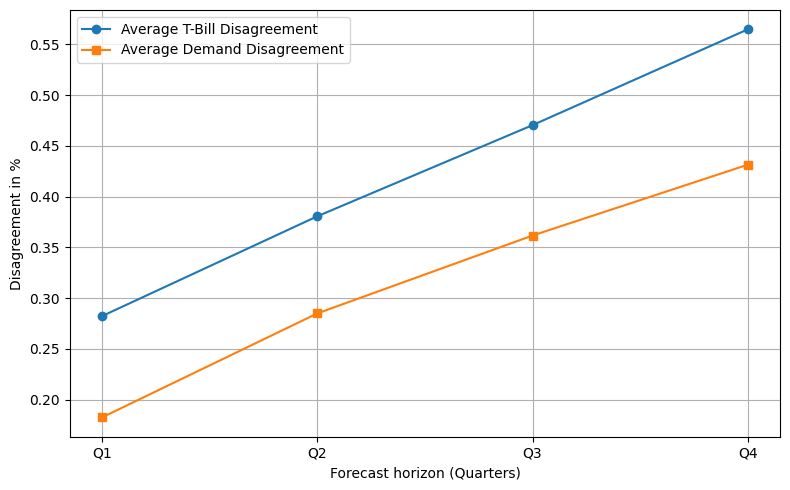

D_DISQ1    0.182507
D_DISQ2    0.284901
D_DISQ3    0.361594
D_DISQ4    0.431343
dtype: float64
r_DIS_Q1    0.282301
r_DIS_Q2    0.380585
r_DIS_Q3    0.470350
r_DIS_Q4    0.564665
dtype: float64
The average ratio of D_DIS to r_DIS for the four quarters is: D_DISQ1    NaN
D_DISQ2    NaN
D_DISQ3    NaN
D_DISQ4    NaN
r_DIS_Q1   NaN
r_DIS_Q2   NaN
r_DIS_Q3   NaN
r_DIS_Q4   NaN
dtype: float64


In [14]:
# Calculate the averages for each quarter
r_DIS_avg = merged_df[['r_DIS_Q1', 'r_DIS_Q2', 'r_DIS_Q3', 'r_DIS_Q4']].mean()
D_DIS_avg = merged_df[['D_DISQ1', 'D_DISQ2', 'D_DISQ3', 'D_DISQ4']].mean()

# Create a plot
plt.figure(figsize=(8, 5))
plt.plot(['Q1', 'Q2', 'Q3', 'Q4'], r_DIS_avg, marker='o', label='Average T-Bill Disagreement')
plt.plot(['Q1', 'Q2', 'Q3', 'Q4'], D_DIS_avg, marker='s', label='Average Demand Disagreement')
plt.xlabel('Forecast horizon (Quarters)')
plt.ylabel('Disagreement in %')
#plt.title('Average of r_DIS and D_DIS for Q1-Q4')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
print(D_DIS_avg)
print(r_DIS_avg)
# Calculate the average ratio D_DIS/r_DIS for each quarter
ratio_avg = (D_DIS_avg / r_DIS_avg)
print(f"The average ratio of D_DIS to r_DIS for the four quarters is: {ratio_avg}")

Next parts also involve the model. Here there are some additional code that has to be run if you want to rerun everything. The files we pre-calculated values are loaded below. To rerun everything (set to fewer paths and T to save time) run 
- ReplicationExampleForDDTS.ipynb
- Files are saved with _SHORT, i.e., DIS02V2.npy is DIS02V2_SHORTTEST.npy 
- Replace file name below to use your own results

In [15]:
data02 = np.load('Data/Model Disagreement/DIS02V2.npy')
data04 = np.load('Data/Model Disagreement/DIS04V2.npy')
data06 = np.load('Data/Model Disagreement/DIS06V2.npy')
data08 = np.load('Data/Model Disagreement/DIS08V2.npy')

meanDIS02 = np.mean(data02, axis=0) * 100
meanDIS04 = np.mean(data04, axis=0) * 100
meanDIS06 = np.mean(data06, axis=0) * 100
meanDIS08 = np.mean(data08, axis=0) * 100

Creating Figure 2

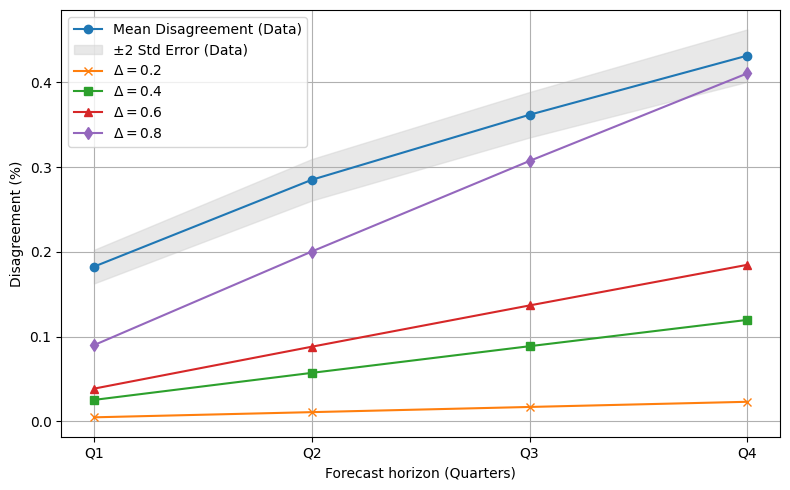

In [16]:
# Combine these into a DataFrame.
df_disagreement = pd.DataFrame({
    'D_DISQ1': D_DIS_Q1,
    'D_DISQ2': D_DIS_Q2,
    'D_DISQ3': D_DIS_Q3,
    'D_DISQ4': D_DIS_Q4
}).reset_index()

# Calculate the mean disagreement for each quarter across all years.
mean_dis_q1 = df_disagreement['D_DISQ1'].mean()
mean_dis_q2 = df_disagreement['D_DISQ2'].mean()
mean_dis_q3 = df_disagreement['D_DISQ3'].mean()
mean_dis_q4 = df_disagreement['D_DISQ4'].mean()

# Calculate the standard deviation of the means (standard error) for each quarter.
std_err_q1 = df_disagreement['D_DISQ1'].std() / (len(df_disagreement['D_DISQ1'])**0.5)
std_err_q2 = df_disagreement['D_DISQ2'].std() / (len(df_disagreement['D_DISQ2'])**0.5)
std_err_q3 = df_disagreement['D_DISQ3'].std() / (len(df_disagreement['D_DISQ3'])**0.5)
std_err_q4 = df_disagreement['D_DISQ4'].std() / (len(df_disagreement['D_DISQ4'])**0.5)

# Create lists for plotting.
quarters = ['Q1', 'Q2', 'Q3', 'Q4']
mean_disagreements = [mean_dis_q1, mean_dis_q2, mean_dis_q3, mean_dis_q4]
std_errors = [std_err_q1, std_err_q2, std_err_q3, std_err_q4]

# Create the plot.
plt.figure(figsize=(8, 5))
plt.plot(quarters, mean_disagreements, label='Mean Disagreement (Data)', marker='o')

# Plotting the ±2 standard error bands.
plt.fill_between(
    quarters,
    [m - 2 * se for m, se in zip(mean_disagreements, std_errors)],
    [m + 2 * se for m, se in zip(mean_disagreements, std_errors)],
    color='lightgray',
    alpha=0.5,
    label='±2 Std Error (Data)'
)

# Add the additional mean lines for DIS02, DIS04, DIS06, and DIS08.
plt.plot(quarters, meanDIS02, label=r'$\Delta = 0.2$', marker='x')
plt.plot(quarters, meanDIS04, label=r'$\Delta = 0.4$', marker='s')
plt.plot(quarters, meanDIS06, label=r'$\Delta = 0.6$', marker='^')
plt.plot(quarters, meanDIS08, label=r'$\Delta = 0.8$', marker='d')

# Add labels and title.
plt.xlabel('Forecast horizon (Quarters)')
plt.ylabel('Disagreement (%)')
#plt.title('Demand Disagreement by Quarter')

# Add the legend in the top-left corner.
plt.legend(loc='upper left')

# Display grid and layout.
plt.grid(True)
plt.tight_layout()

# Display the plot.
plt.show()

Next we create simulated data and store summary stats in files. This is done in two steps using the following code:
- Run CreateGridYieldsandYieldVola.ipynb 
- Run simulateYieldsandYieldVolas.py to create simulated paths
- Run UnconditionalYieldCurveFileCreation.ipynb using the input files h5 files created in simulateYieldsandYieldsVolas.py (replace with TEST as prefix in the filename if you want to use your own generated files)
The output from UnconditionalYildCurveFileCreation.py has been converted to an excel file called resultsLongV2.xlsx. The only difference is the order of the rows (ascending in DEL) 

In [17]:
# Load the Excel file
file_path = 'Data/Model Disagreement/resultsLongV2.xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head(), data.columns

(   DEL  Mean Alpha  Std Alpha    Mean f     Std f  Mean Short Rate  \
 0  0.0    0.500272   0.158673  0.334387  0.099215         0.011698   
 1  0.1    0.496225   0.159530  0.333352  0.141345         0.012762   
 2  0.2    0.503566   0.159398  0.332591  0.186290         0.014250   
 3  0.3    0.500645   0.155943  0.318509  0.216654         0.016250   
 4  0.4    0.507426   0.158371  0.317308  0.244677         0.017262   
 
    Std Short Rate   Mean y1   Mean y2   Mean y3  ...  Mean StdB3  Std StdB3  \
 0        0.005176  0.011700  0.011699  0.011697  ...    0.003962   0.000821   
 1        0.007311  0.012769  0.012779  0.012788  ...    0.003156   0.000966   
 2        0.013315  0.014295  0.014345  0.014390  ...    0.008931   0.002498   
 3        0.017870  0.016340  0.016435  0.016521  ...    0.013526   0.005227   
 4        0.021262  0.017406  0.017554  0.017690  ...    0.017149   0.008286   
 
    Mean StdB4  Std StdB4  Mean StdB5  Std StdB5  Mean StdB7  Std StdB7  \
 0    0.005106 

Creating Figure 3 - Each panel in Figure 3 has its own code

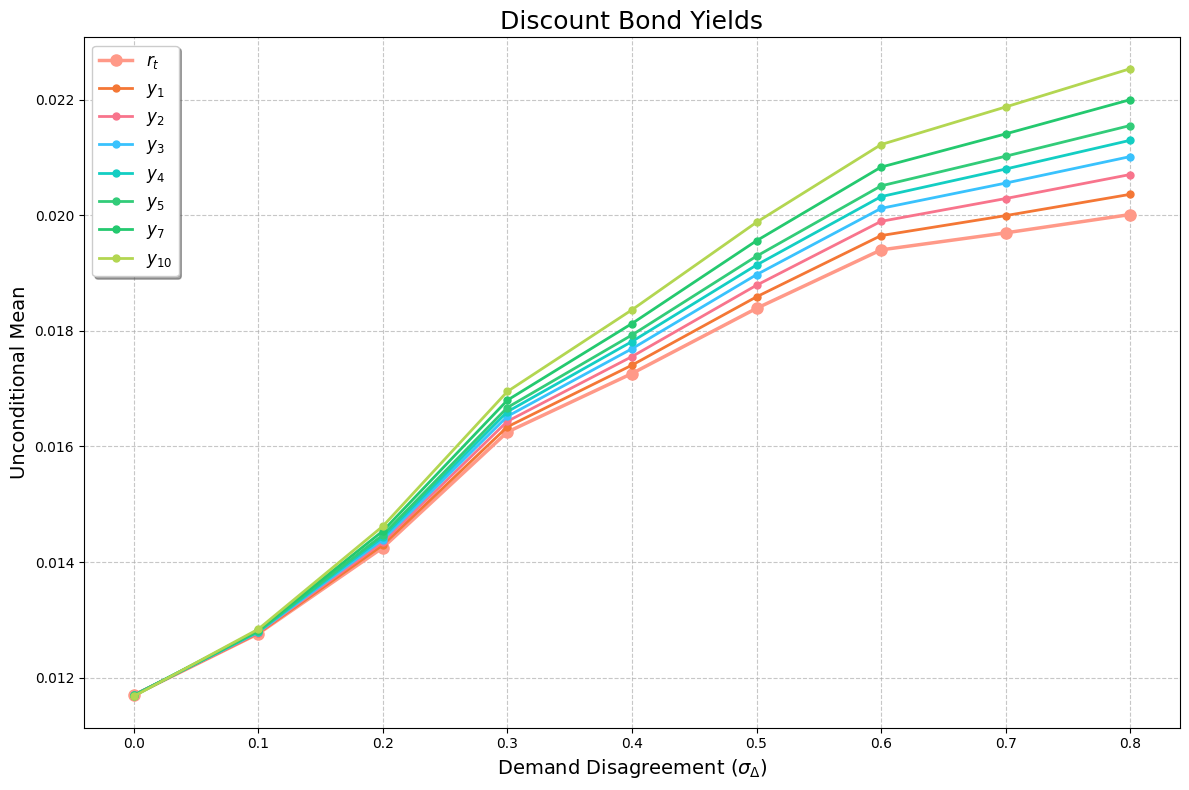

In [18]:
# Define a gradient of colors
colors = ['#ff9988', '#f47735', '#f8748c', '#39c2fd', '#13cec3', '#32cc79', '#24c96f', '#b3d651']

# Set up the plot
plt.figure(figsize=(12, 8))  # Increased figure size for better readability

# Plot the mean short rate with a thicker line and larger markers
plt.plot(data['DEL'][:-1], data['Mean Short Rate'][:-1], 
         label='$r_t$', marker='o', markersize=8, linestyle='-', linewidth=2.5, color=colors[0])

# Plot each mean yield curve with a specific color from the gradient, larger markers, and thicker lines
yield_terms = [1, 2, 3, 4, 5, 7, 10]
for i, term in enumerate(yield_terms):
    plt.plot(data['DEL'][:-1], data[f'Mean y{term}'][:-1], 
             label=f'$y_{{{term}}}$', marker='.', markersize=10, linewidth=2, color=colors[i + 1])

# Increase font sizes for better readability
plt.xlabel(r'Demand Disagreement $(\sigma_{\Delta})$', fontsize=14)
plt.ylabel('Unconditional Mean', fontsize=14)
plt.title('Discount Bond Yields', fontsize=18)

# Display grid with transparency for better readability
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Add some padding around the edges for clarity
plt.margins(x=0.05, y=0.05)

# Improve the legend readability by making it larger and more spaced out
plt.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Define the sv variable (set to 1 to save the plot, 0 to not save)
sv = 1
# Save the figure as a PNG file
if sv == 1:
    # Save the figure as a PNG file if sv is 1
    plt.savefig('UnconditionalYieldsJFE.png', format='png')
    
# Show the plot
plt.show()


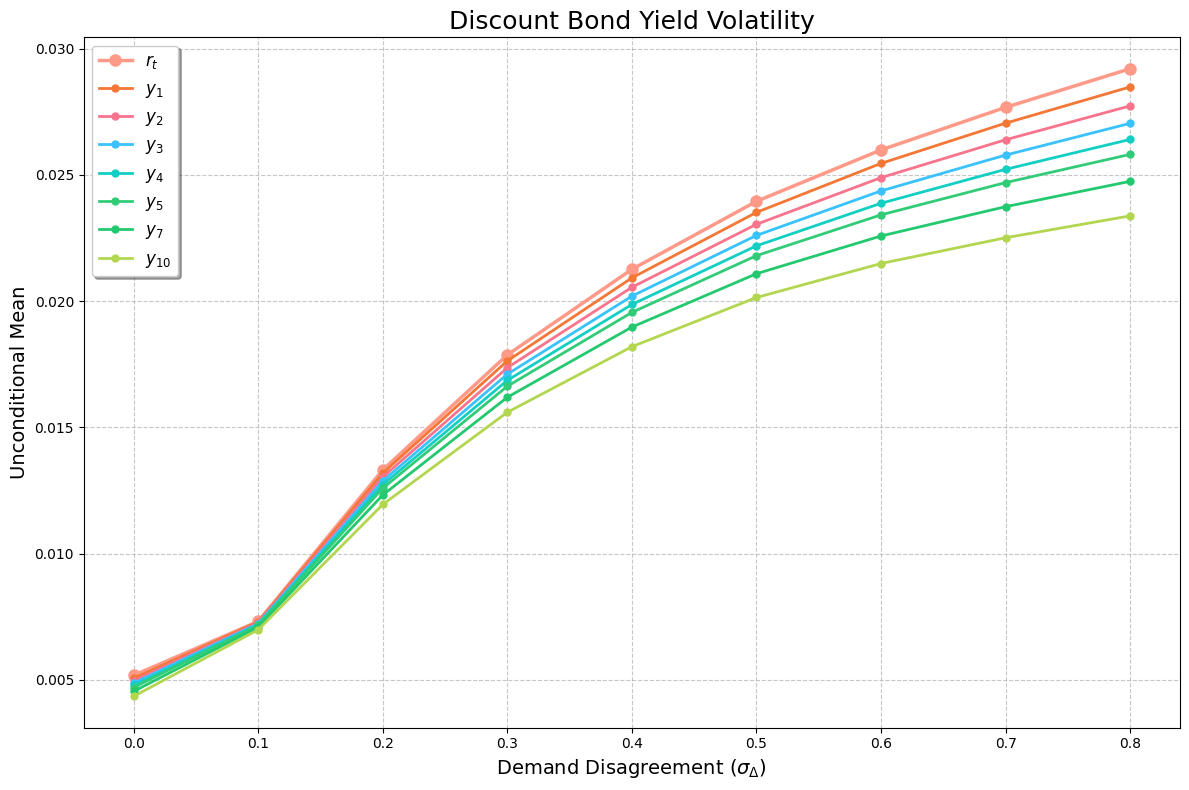

In [19]:
# Define a gradient of colors
colors = ['#ff9988', '#f47735', '#f8748c', '#39c2fd', '#13cec3', '#32cc79', '#24c96f', '#b3d651']

# Set up the plot with an increased figure size
plt.figure(figsize=(12, 8))

# Plot the standard deviation of the short rate with a larger marker and thicker line, excluding the last data point
plt.plot(data['DEL'][:-1], data['Std Short Rate'][:-1], 
         label='$r_t$', marker='o', markersize=8, linestyle='-', linewidth=2.5, color=colors[0])

# Plot each yield curve standard deviation, excluding the last data point, with larger markers and thicker lines
yield_terms = [1, 2, 3, 4, 5, 7, 10]
for i, term in enumerate(yield_terms):
    plt.plot(data['DEL'][:-1], data[f'Std Y{term}'][:-1], 
             label=f'$y_{{{term}}}$', marker='.', markersize=10, linewidth=2, color=colors[i + 1])

# Increase font sizes for better readability
plt.xlabel(r'Demand Disagreement $(\sigma_{\Delta})$', fontsize=14)
plt.ylabel('Unconditional Mean', fontsize=14)
plt.title('Discount Bond Yield Volatility', fontsize=18)

# Add grid with transparency to improve readability
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Add margins around the plot for better spacing
plt.margins(x=0.05, y=0.05)

# Improve the legend by making it larger and with better spacing
plt.legend(fontsize=12, loc='upper left', frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent any overlapping
plt.tight_layout()

# Save the figure as a PNG file
if sv == 1:
    # Save the figure as a PNG file if sv is 1
    plt.savefig('UnconditionalYieldVolatilitiesJFE.png', format='png')
    
# Show the plot
plt.show()

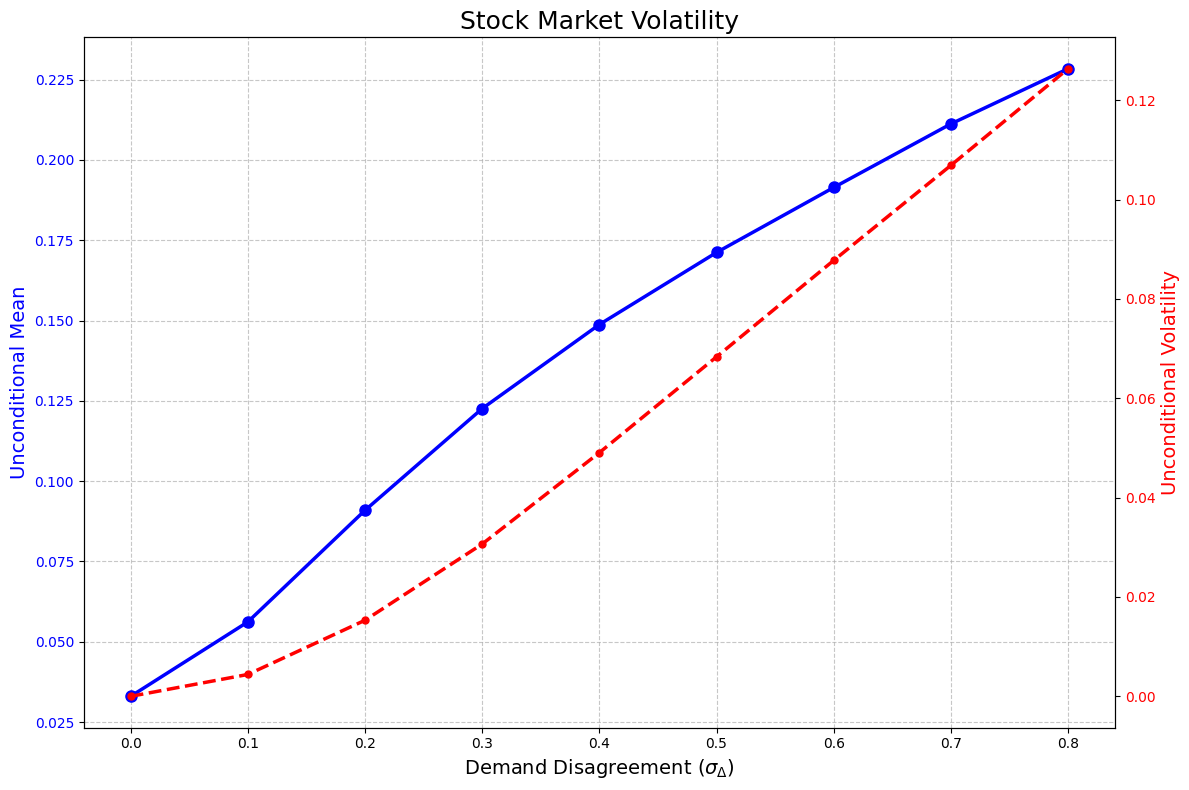

In [20]:
# Set up the plot with an increased figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the stock market volatility ('Mean StdR') on the left y-axis with blue color
ax1.plot(data['DEL'][:-1], data['Mean StdR'][:-1], 
         label='Stock Market Volatility', marker='o', markersize=8, linestyle='-', linewidth=2.5, color='blue')

# Set the label for the left y-axis (Stock Market Volatility) with blue color
ax1.set_xlabel(r'Demand Disagreement $(\sigma_{\Delta})$', fontsize=14)
ax1.set_ylabel('Unconditional Mean', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add gridlines on the first axis
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the volatility of the stock market volatility ('Std StdR') on the right y-axis with red color
ax2.plot(data['DEL'][:-1], data['Std StdR'][:-1], 
         label='Unconditional Volatility', marker='.', markersize=10, linestyle='--', linewidth=2.5, color='red')

# Set the label for the right y-axis (Volatility of Stock Market Volatility) with red color
ax2.set_ylabel('Unconditional Volatility', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Stock Market Volatility', fontsize=18)

# Adjust layout to prevent any overlap
fig.tight_layout()

# Save the figure as a PNG file
if sv == 1:
    # Save the figure as a PNG file if sv is 1
    plt.savefig('APUnconditionalStockMarketVolatilityJFE.png', format='png')


# Show the plot
plt.show()

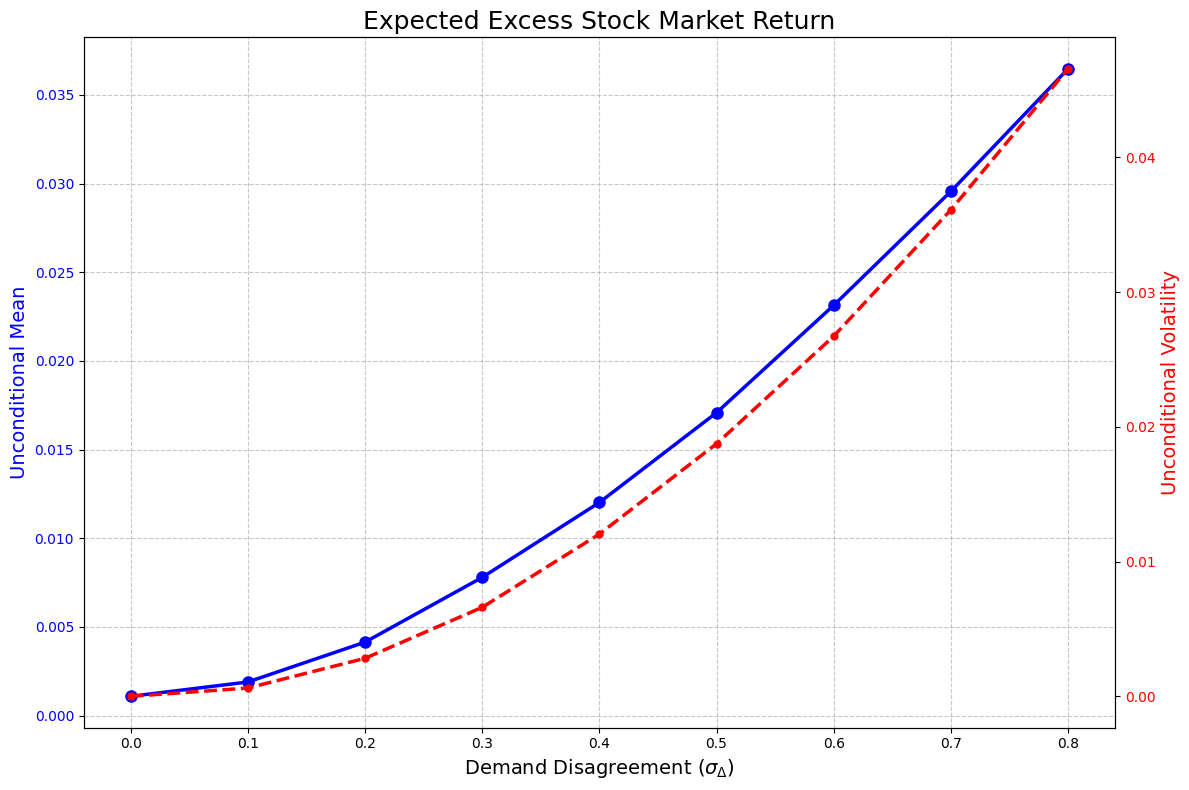

In [21]:
# Set up the plot with an increased figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the Expected Excess Return ('Mean ExR') on the left y-axis with blue color
ax1.plot(data['DEL'][:-1], data['Mean ExR'][:-1], 
         label='Expected Excess Return', marker='o', markersize=8, linestyle='-', linewidth=2.5, color='blue')

# Set the label for the left y-axis (Expected Excess Return) with blue color
ax1.set_xlabel(r'Demand Disagreement $(\sigma_{\Delta})$', fontsize=14)
ax1.set_ylabel('Unconditional Mean', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add gridlines on the first axis
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the volatility of the Expected Excess Return ('Std ExR') on the right y-axis with red color
ax2.plot(data['DEL'][:-1], data['Std ExR'][:-1], 
         label='Unconditional Volatility', marker='.', markersize=10, linestyle='--', linewidth=2.5, color='red')

# Set the label for the right y-axis (Volatility of Expected Excess Return) with red color
ax2.set_ylabel('Unconditional Volatility', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Expected Excess Stock Market Return', fontsize=18)

# Adjust layout to prevent any overlap
fig.tight_layout()

# Save the figure as a PNG file
if sv == 1:
    # Save the figure as a PNG file if sv is 1
    plt.savefig('APUnconditionalExcessReturnsJFE.png', format='png')

# Show the plot
plt.show()

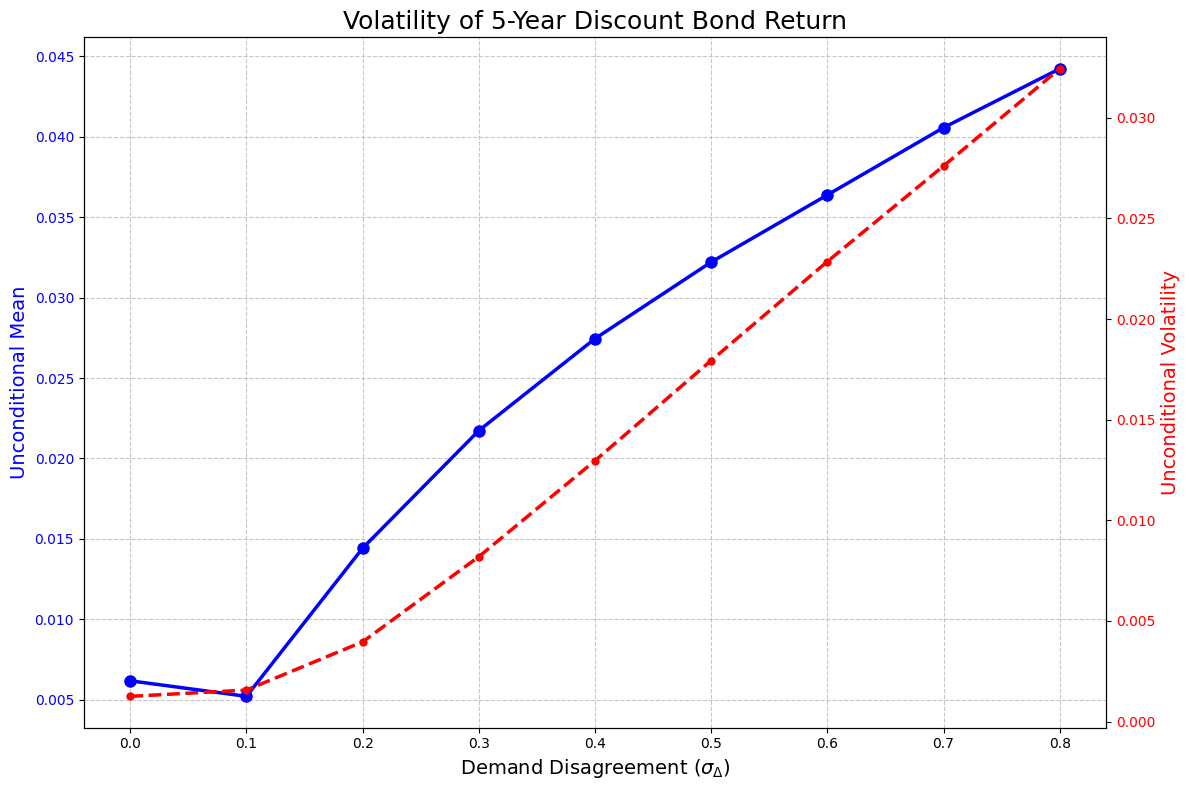

In [22]:
# Set up the plot with an increased figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the stock market volatility ('Mean StdR') on the left y-axis with blue color
ax1.plot(data['DEL'][:-1], data['Mean StdB5'][:-1], 
         label='Volatility of 5-Year Discount Bond Return', marker='o', markersize=8, linestyle='-', linewidth=2.5, color='blue')

# Set the label for the left y-axis (Stock Market Volatility) with blue color
ax1.set_xlabel(r'Demand Disagreement $(\sigma_{\Delta})$', fontsize=14)
ax1.set_ylabel('Unconditional Mean', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add gridlines on the first axis
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the volatility of the stock market volatility ('Std StdR') on the right y-axis with red color
ax2.plot(data['DEL'][:-1], data['Std StdB5'][:-1], 
         label='Unconditional Volatility', marker='.', markersize=10, linestyle='--', linewidth=2.5, color='red')

# Set the label for the right y-axis (Volatility of Stock Market Volatility) with red color
ax2.set_ylabel('Unconditional Volatility', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Volatility of 5-Year Discount Bond Return', fontsize=18)

# Adjust layout to prevent any overlap
fig.tight_layout()

# Save the figure as a PNG file
if sv == 1:
    # Save the figure as a PNG file if sv is 1
    plt.savefig('BondVola5yearJFE.png', format='png')
    
# Show the plot
plt.show()

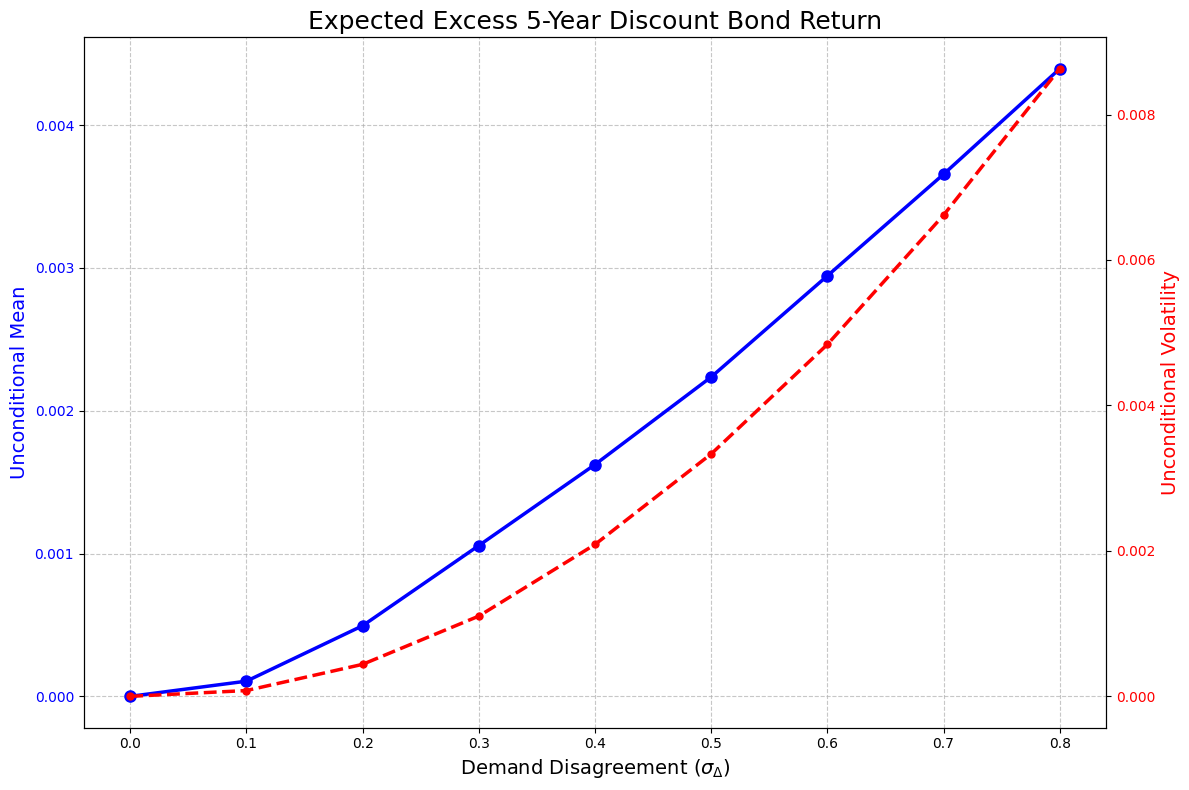

In [23]:
# Set up the plot with an increased figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot the Expected Excess Return ('Mean ExR') on the left y-axis with blue color
ax1.plot(data['DEL'][:-1], data['Mean ExR5'][:-1], 
         label='Expected Excess 5-Year Discount Bond Return', marker='o', markersize=8, linestyle='-', linewidth=2.5, color='blue')

# Set the label for the left y-axis (Expected Excess Return) with blue color
ax1.set_xlabel(r'Demand Disagreement $(\sigma_{\Delta})$', fontsize=14)
ax1.set_ylabel('Unconditional Mean', fontsize=14, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Add gridlines on the first axis
ax1.grid(True, which='both', linestyle='--', alpha=0.7)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the volatility of the Expected Excess Return ('Std ExR') on the right y-axis with red color
ax2.plot(data['DEL'][:-1], data['Std ExR5'][:-1], 
         label='Unconditional Volatility', marker='.', markersize=10, linestyle='--', linewidth=2.5, color='red')

# Set the label for the right y-axis (Volatility of Expected Excess Return) with red color
ax2.set_ylabel('Unconditional Volatility', fontsize=14, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title to the plot
plt.title('Expected Excess 5-Year Discount Bond Return', fontsize=18)

# Adjust layout to prevent any overlap
fig.tight_layout()

# Save the figure as a PNG file
if sv == 1:
    # Save the figure as a PNG file if sv is 1
    plt.savefig('ExRBond5yearJFE.png', format='png')
    
# Show the plot
plt.show()


Creating figures that are conditional on $f$

In [24]:
#Paramters
rhoA = -0.015
rhoB = 0.025
DEL = 0.8
nu = 0.02
muY = 0.02
sigY = 0.033
sigl = 0.1
kapl = 0.01
lbar = 0
# some pre caluclations
phiA = 1/(nu+rhoA)
phiB = 1/(nu+rhoB)

Creating Figure 4

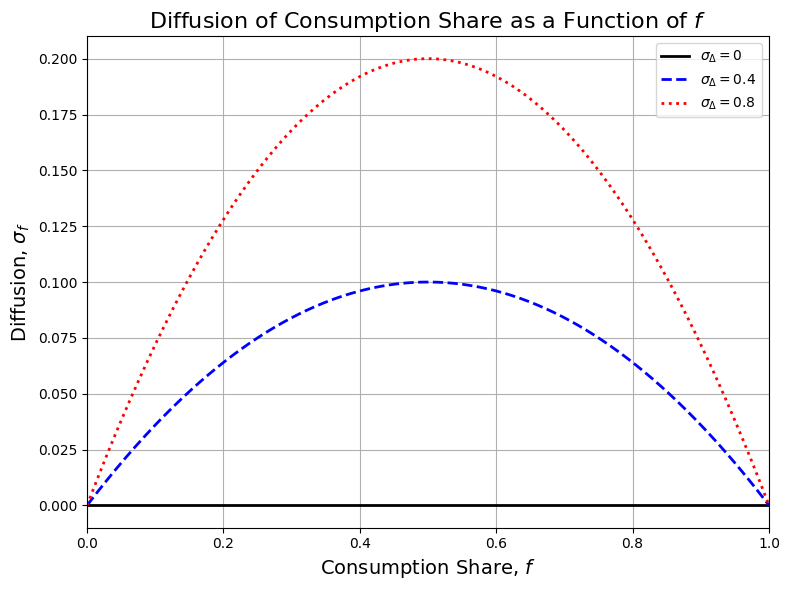

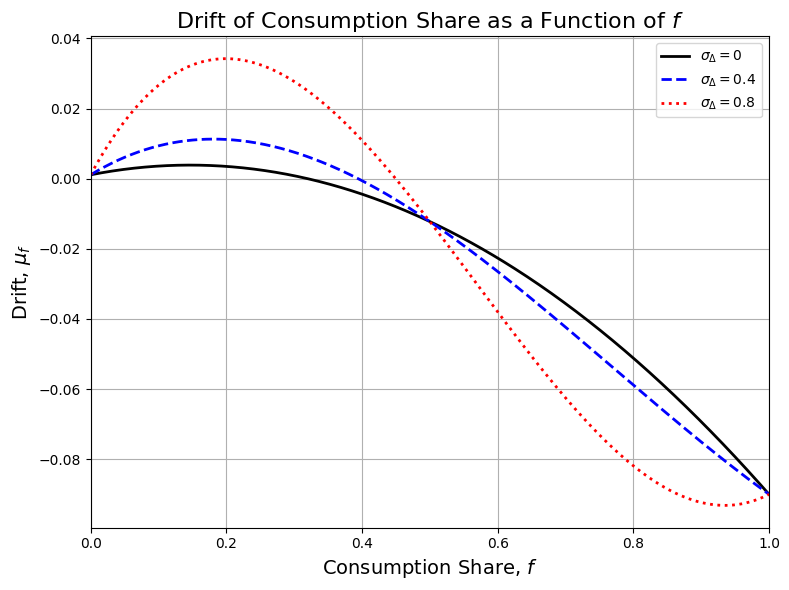

In [25]:
# Create the data for f between 0 and 1
alp = 0.5
f = np.linspace(0, 1, 500)  # 500 points between 0 and 1

# DEL values to iterate over
DEL_values = [0, 0.4, 0.8]
colors = ['black', 'blue', 'red']  # Colors for each DEL
linestyles = ['-', '--', ':']  # Different line styles for visibility in black-and-white

# Plot for sigf (diffusion of consumption share)
plt.figure(figsize=(8, 6))
for DEL, color, ls in zip(DEL_values, colors, linestyles):
    # Define the diffusion (sigma_f)
    sigf = DEL * f * (1 - f)  # Diffusion of the consumption share
    plt.plot(f, sigf, label=rf'$\sigma_{{\Delta}} = {DEL}$', linestyle=ls, linewidth=2, color=color)
plt.xlim(min(f), max(f))    
# Add labels and title for sigma_f
plt.xlabel(r'Consumption Share, $f$', fontsize=14)
plt.ylabel(r'Diffusion, $\sigma_f$', fontsize=14)
plt.title(r'Diffusion of Consumption Share as a Function of $f$', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot for muf (drift of consumption share)
plt.figure(figsize=(8, 6))
for DEL, color, ls in zip(DEL_values, colors, linestyles):
    # Define the functions for drift (mu_f)
    phi = f * phiA + (1 - f) * phiB
    betA = (nu + rhoA) * phi
    betB = (nu + rhoB) * phi
    DELrho = rhoB - rhoA
    muf = nu * (alp * betA * (1 - f) - (1 - alp) * betB * f) + DELrho * f * (1 - f) + DEL**2 * (0.5 - f) * f * (1 - f)  # Drift of the consumption share
    plt.plot(f, muf, label=rf'$\sigma_{{\Delta}} = {DEL}$', linestyle=ls, linewidth=2, color=color)
plt.xlim(min(f), max(f))
# Add labels and title for mu_f
plt.xlabel(r'Consumption Share, $f$', fontsize=14)
plt.ylabel(r'Drift, $\mu_f$', fontsize=14)
plt.title(r'Drift of Consumption Share as a Function of $f$', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Data for the histograms for DEL= [0.0, 0.4, 0.8] 
Note that the way these are created is to load the files previously used

In [26]:
# filePath = 'Data/Model Disagreement/results_20240725_200337.h5'
# df00 = pd.read_hdf(filePath, key='df')
# filePath = 'Data/Model Disagreement/results_20240720_145701.h5'
# df04 = pd.read_hdf(filePath, key='df')
# filePath = 'Data/Model Disagreement/results_20240720_183617.h5'
# df08 = pd.read_hdf(filePath, key='df')
filePath = 'Data/Model Disagreement/resultsLong_20240727_100833.h5'
df00 = pd.read_hdf(filePath, key='df')
filePath = 'Data/Model Disagreement/resultsLong_20240726_211654.h5'
df04 = pd.read_hdf(filePath, key='df')
filePath = 'Data/Model Disagreement/results_20240726_232958.h5'
df08 = pd.read_hdf(filePath, key='df')

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\D'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\D'
C:\Users\chris\AppData\Local\Temp\ipykernel_517432\2615784165.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.hist(df00['f'], bins=nbins, color='black', alpha=alphaValue, label='$\sigma_{{\Delta}} = 0$', edgecolor='black', density=True)
C:\Users\chris\AppData\Local\Temp\ipykernel_517432\2615784165.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.hist(df04['f'], bins=nbins, color='blue', alpha=alphaValue, label='$\sigma_{{\Delta}}= 0.4$', edgecolor='black', density=True)
C:\Users\chris\AppData\Local\Temp\ipykernel_517432\2615784165.py:18: SyntaxWarning: invalid escape sequ

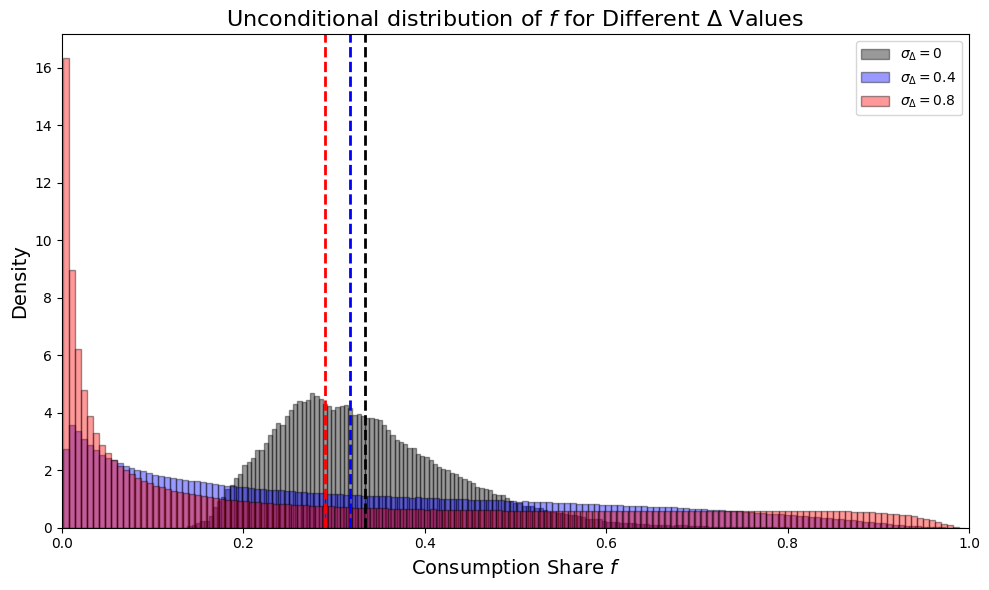

In [27]:
nbins = 150
alphaValue = 0.4

# Create the figure
plt.figure(figsize=(10, 6))

# Plot the histogram for df00 (black)
plt.hist(df00['f'], bins=nbins, color='black', alpha=alphaValue, label='$\sigma_{{\Delta}} = 0$', edgecolor='black', density=True)
# Add a vertical line for the mean of df00
plt.axvline(df00['f'].mean(), color='black', linestyle='--', linewidth=2)

# Plot the histogram for df04 (blue)
plt.hist(df04['f'], bins=nbins, color='blue', alpha=alphaValue, label='$\sigma_{{\Delta}}= 0.4$', edgecolor='black', density=True)
# Add a vertical line for the mean of df04
plt.axvline(df04['f'].mean(), color='blue', linestyle='--', linewidth=2)

# Plot the histogram for df08 (red)
plt.hist(df08['f'], bins=nbins, color='red', alpha=alphaValue, label='$\sigma_{{\Delta}} = 0.8$', edgecolor='black', density=True)
# Add a vertical line for the mean of df08
plt.axvline(df08['f'].mean(), color='red', linestyle='--', linewidth=2)

# Set the x-axis limits to be between 0 and 1
plt.xlim(0, 1)

# Add labels and title
plt.xlabel('Consumption Share $f$', fontsize=14)
plt.ylabel('Density', fontsize=14)  # Change the y-axis label to 'Density' as we are now normalizing the histograms
plt.title('Unconditional distribution of $f$ for Different $\Delta$ Values', fontsize=16)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


Creating Figure 5

The following data is created using the CreateConditionalYieldVolasAndRiskPremia.ipynb. The reason for this is that it utilizes the GPU (Can do CPU too). The file name is "model_data_for_f_plotsV4.npz" 

In [28]:
data = np.load('Data/Model Disagreement/model_data_for_f_plotsV4.npz', allow_pickle=True)

# Accessing the stored data
pars = data['pars']
taus = data['taus']
f_values = data['f_values']
alp = data['alp']
BondRetStd_by_tau = data['BondRetStd_by_tau'].item()  # Convert back to dictionary
RxValues_by_tau = data['RxValues_by_tau'].item()  # Convert back to dictionary
sigrValues_by_tau = data['sigrValues_by_tau'].item()  # Convert back to dictionary
sigyValues_by_tau = data['sigyValues_by_tau'].item()  # Convert back to dictionary
y_values_by_tau = data['y_values_by_tau'].item()  # Convert back to dictionary

Creating the stock market volatility (minus fundamental volatility)

In [29]:
def getStockMarketdiffusion(f, pars):
  rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars
  phiA = 1/(rhoA + nu)
  phiB = 1/(rhoB + nu)
  phi = f*phiA + (1-f)*phiB
  sigRalp = ((phiA-phiB)/phi)*f*(1-f)*DEL
  return sigRalp

In [30]:
stdRexcess = []
excessRet = []
for f in f_values:
    sigR = getStockMarketdiffusion(f, pars)
    stdRexcess.append(sigR)
    ExR = DEL*(0.5-f)*sigR
    excessRet.append(ExR)

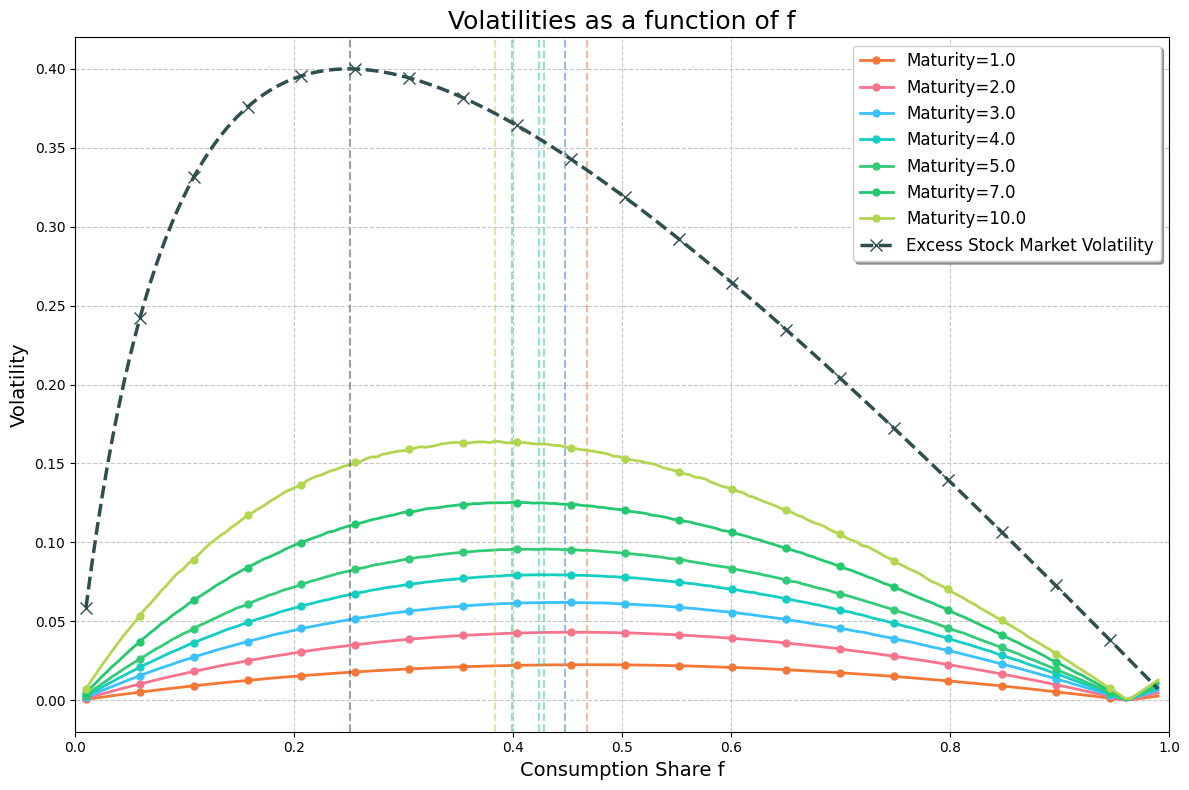

In [31]:

# Define a gradient of colors
colors = ['#ff9988', '#f47735', '#f8748c', '#39c2fd', '#13cec3', '#32cc79', '#24c96f', '#b3d651']

# Set up the plot with an increased figure size
plt.figure(figsize=(12, 8))


# Plot each bond return standard deviation for the remaining taus
for i, tau in enumerate(taus[1:]):  # Skip the first tau
    plt.plot(f_values, BondRetStd_by_tau[tau], 
             label=f'Maturity={tau}', marker='.', markersize=10, linewidth=2, color=colors[i + 1], markevery=10)
    # Add a vertical line at the max value of BondRetStd_by_tau[tau]
    max_f_bond_ret = f_values[np.argmax(BondRetStd_by_tau[tau])]
    plt.axvline(x=max_f_bond_ret, color=colors[i + 1], linestyle='--', alpha=0.5)
# Plot the excess stock market volatility
plt.plot(f_values, stdRexcess, 
         label='Excess Stock Market Volatility', marker='x', markersize=8, linestyle='--', linewidth=2.5, color='#2f4f4f', markevery=10)
# Add a vertical line at the max value of stdRexcess
max_f_std_rexcess = f_values[np.argmax(stdRexcess)]
plt.axvline(x=max_f_std_rexcess, color='#2f4f4f', linestyle='--', alpha=0.5)
# Increase font sizes for better readability
plt.xlabel('Consumption Share f', fontsize=14)
plt.ylabel('Volatility', fontsize=14)
plt.title('Volatilities as a function of f', fontsize=18)

# Add grid with transparency to improve readability
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Add margins around the plot for better spacing
plt.margins(x=0.05, y=0.05)

# Truncate the x-axis to min and max of f_values
plt.xlim(min(f_values), max(f_values))

# Get the current ticks and add 0.5 to the list if it is not already present
current_ticks = plt.gca().get_xticks().tolist()
if 0.5 not in current_ticks:
    current_ticks.append(0.5)

# Set the x-axis ticks to include 0.5
plt.xticks(current_ticks)

# Move the legend to the upper right corner
plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent any overlapping
plt.tight_layout()

# Show the plot
plt.show()

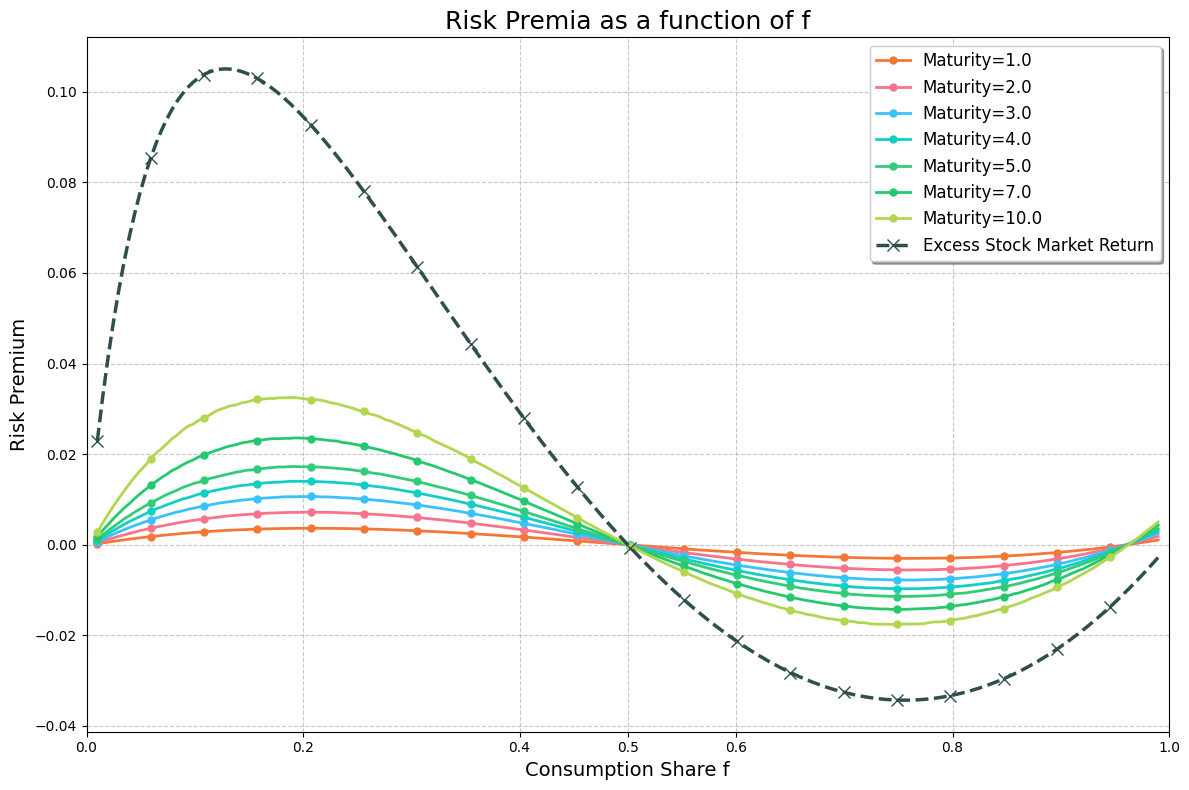

In [32]:
# Define a gradient of colors
colors = ['#ff9988', '#f47735', '#f8748c', '#39c2fd', '#13cec3', '#32cc79', '#24c96f', '#b3d651']

# Set up the plot with an increased figure size
plt.figure(figsize=(12, 8))

# Plot each bond risk premium for the remaining taus (skip the first tau if needed)
for i, tau in enumerate(taus[1:]):  # Skip the first tau
    plt.plot(f_values, RxValues_by_tau[tau], 
             label=f'Maturity={tau}', marker='.', markersize=10, linewidth=2, color=colors[i + 1], markevery=10)

# Plot the excess stock market return
plt.plot(f_values, excessRet, 
         label='Excess Stock Market Return', marker='x', markersize=8, linestyle='--', linewidth=2.5, color='#2f4f4f', markevery=10)



# Increase font sizes for better readability
plt.xlabel('Consumption Share f', fontsize=14)
plt.ylabel('Risk Premium', fontsize=14)
plt.title('Risk Premia as a function of f', fontsize=18)

# Add grid with transparency to improve readability
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Add margins around the plot for better spacing
plt.margins(x=0.05, y=0.05)

# Truncate the x-axis to min and max of f_values
plt.xlim(min(f_values), max(f_values))

# Get the current ticks and add 0.5 to the list if it is not already present
current_ticks = plt.gca().get_xticks().tolist()
if 0.5 not in current_ticks:
    current_ticks.append(0.5)

# Set the x-axis ticks to include 0.5
plt.xticks(current_ticks)

# Move the legend to the upper right corner
plt.legend(fontsize=12, loc='upper right', frameon=True, fancybox=True, shadow=True)

# Adjust layout to prevent any overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [33]:
doV0 = False
doV1 = False
disr = False

In [34]:
# DisagreementTS2024ForRegressionsV0 is based on running log interest rate disagreement on log macro then taking the exp of the residuals
# DisagreementTS2024ForRegressionsV1 is based on running interest rate disagreement on macro then taking the exp of the residuals
# DisagreementTS2024ForRegressions is based on running the panel regression of interest forecast on macro (pooled) then taking the cross-sectional standard deviation of the residuals
# These are all created above, but I use the excel files here

if doV0:
    df1 = pd.read_excel('Data/DisagreementTS2024ForRegressionsV0.xlsx')
else: 
    if doV1:
        df1 = pd.read_excel('Data/DisagreementTS2024ForRegressionsV1.xlsx')
    else:
        df1 = pd.read_excel('Data/DisagreementTS2024ForRegressions.xlsx')
# Display the first few rows to understand the structure
df1.head()

,YEAR,QUARTER,residRegMainQ1_std,residRegMainQ2_std,residRegMainQ3_std,residRegMainQ4_std,r_DIS_Q1,r_DIS_Q2,r_DIS_Q3,r_DIS_Q4,M_DIS_Q1,M_DIS_Q2,M_DIS_Q3,M_DIS_Q4
0,1981,3,0.950742,1.016080,1.350036,1.374542,1.098880,1.433488,1.849760,2.124874,0.586624,0.578824,0.653578,0.650835
1,1981,4,1.111516,1.306320,1.558539,2.028143,1.871463,1.878579,2.038642,2.312525,1.109980,1.127764,1.117840,1.111345
2,1982,1,0.737521,0.898252,1.215438,1.392805,1.177056,1.277955,1.348456,1.972905,0.679446,0.659629,0.690274,0.776698
3,1982,2,0.664249,0.968499,0.921283,0.906874,0.965471,1.243456,1.211561,1.295480,0.581794,0.690059,0.744772,0.824624
4,1982,3,0.678524,1.081599,1.024741,1.089716,1.518766,1.510213,1.498588,1.651161,1.052907,0.975771,0.944179,0.940273


Creating a new variable called DIS that is scaled

In [35]:
# Check if 'M_DISQ4' is present in df1
if 'M_DIS_Q4' in df1.columns:
    df1['MDIS'] = df1['M_DIS_Q4'] / 100
if disr:
    df1['DIS'] = df1['r_DIS_Q4']/100
    df1.head()
else:
    df1['DIS'] = df1['residRegMainQ4_std']/100
    df1.head()

Getting nominal yields from https://www.federalreserve.gov/data/nominal-yield-curve.htm

In [36]:
# Load the datasets
file_path = 'Data/NominalYields.xlsx'
xls = pd.ExcelFile(file_path)
df = pd.read_excel(xls, 'Sheet1')

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [37]:
# Resample the data to quarterly frequency, taking the mean of the values
quarterly_df = df.resample('QE', on='Date').mean()

In [38]:
# Keep only the columns for 1-5 years, and divide by 100 to convert percentages to decimal form
yieldN = quarterly_df[['Y1', 'Y2', 'Y3', 'Y4', 'Y5']] / 100


In [39]:
# Function to fit AR(1)-GARCH(1,1) model and extract volatility
def fit_ar1_garch11V2(yield_series):
    # Rescale the data to avoid convergence issues
    yield_series_rescaled = yield_series * 100
    
    # Fit AR(1)-GARCH(1,1) model
    # EGarch for exponential GARCH
    model = arch_model(yield_series_rescaled, vol='Garch', p=1, q=1, mean='AR', lags=1)
    res = model.fit(disp='off')
    
    # Extract volatility (conditional standard deviation)
    volatility = res.conditional_volatility / 100  # Scale back the volatility to match original scale
    return volatility

In [40]:
# Fit the model and calculate volatility for each yield
yieldN['Vol_Y1'] = fit_ar1_garch11V2(yieldN['Y1'])
yieldN['Vol_Y2'] = fit_ar1_garch11V2(yieldN['Y2'])
yieldN['Vol_Y3'] = fit_ar1_garch11V2(yieldN['Y3'])
yieldN['Vol_Y4'] = fit_ar1_garch11V2(yieldN['Y4'])
yieldN['Vol_Y5'] = fit_ar1_garch11V2(yieldN['Y5'])

In [41]:
# Set this flag to True or False to control whether to write to Excel
write_to_excel = False  # Change to False if you do not want to write to Excel

# Write the yieldN DataFrame back to an Excel file only if the flag is True
if write_to_excel:
    output_file_path = 'TEST_QuarterlyNominalYieldsManualRuns.xlsx'
    yieldN.to_excel(output_file_path, sheet_name='QuarterlyYields', index=True)
    print(f"Data successfully written to {output_file_path}")
else:
    print("Skipping writing to Excel.")

Skipping writing to Excel.


In [42]:
start_date = '1961-06-30'  # Replace with the actual start date
date_range = pd.date_range(start=start_date, periods=len(yieldN), freq='QE')

yieldN['Date'] = date_range

In [43]:

# Convert YEAR and QUARTER to a datetime format in the resid_df
df1['Date'] = pd.to_datetime(df1['YEAR'].astype(str) + 'Q' + df1['QUARTER'].astype(str))

# Convert the Date in df1 to the last day of the quarter
df1['Date'] = pd.to_datetime(df1['Date']) + pd.offsets.QuarterEnd(0)

# Verify the date adjustment
print(df1[['YEAR', 'QUARTER', 'Date']].head())


yieldN.head()
# Verify the date adjustment
print(df1[['YEAR', 'QUARTER', 'Date']].head())


yieldN.head()


yieldN.head()

   YEAR  QUARTER       Date
0  1981        3 1981-09-30
1  1981        4 1981-12-31
2  1982        1 1982-03-31
3  1982        2 1982-06-30
4  1982        3 1982-09-30
   YEAR  QUARTER       Date
0  1981        3 1981-09-30
1  1981        4 1981-12-31
2  1982        1 1982-03-31
3  1982        2 1982-06-30
4  1982        3 1982-09-30


C:\Users\chris\AppData\Local\Temp\ipykernel_517432\3019851420.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df1['Date'] = pd.to_datetime(df1['YEAR'].astype(str) + 'Q' + df1['QUARTER'].astype(str))


,Y1,Y2,Y3,Y4,Y5,Vol_Y1,Vol_Y2,Vol_Y3,Vol_Y4,Vol_Y5,Date
Date,,,,,,,,,,,
1961-06-30,0.029747,0.033836,0.035800,0.036846,0.037481,NaN,NaN,NaN,NaN,NaN,1961-06-30
1961-09-30,0.029641,0.033868,0.036180,0.037499,0.038319,0.003818,0.003410,0.003071,0.002797,0.002589,1961-09-30
1961-12-31,0.030256,0.033740,0.035889,0.037193,0.037936,0.003221,0.003012,0.002827,0.002648,0.002514,1961-12-31
1962-03-31,0.030959,0.034138,0.035991,0.037125,0.037834,0.002751,0.002683,0.002625,0.002518,0.002444,1962-03-31
1962-06-30,0.028957,0.031573,0.033465,0.034852,0.035888,0.002385,0.002407,0.002446,0.002399,0.002376,1962-06-30


In [44]:
# If 'Date' is in the columns and the index, remove it from the columns to avoid duplication
if 'Date' in yieldN.columns and 'Date' in yieldN.index.names:
    yieldN = yieldN.drop(columns=['Date'])

# Reset index to make sure 'Date' is a column and not an index
if 'Date' in yieldN.index.names:
    yieldN = yieldN.reset_index()

# Similarly, handle df1
if 'Date' in df1.columns and 'Date' in df1.index.names:
    df1 = df1.drop(columns=['Date'])

if 'Date' in df1.index.names:
    df1 = df1.reset_index()

# Now merge the DataFrames on the 'Date' column
if 'M_DIS_Q4' in df1.columns:
    yieldN = yieldN.merge(df1[['Date', 'DIS', 'MDIS']], on='Date', how='left')
else:
    yieldN = yieldN.merge(df1[['Date', 'DIS']], on='Date', how='left')

In [45]:
yieldN.head()

,Date,Y1,Y2,Y3,Y4,Y5,Vol_Y1,Vol_Y2,Vol_Y3,Vol_Y4,Vol_Y5,DIS,MDIS
0,1961-06-30,0.029747,0.033836,0.035800,0.036846,0.037481,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1961-09-30,0.029641,0.033868,0.036180,0.037499,0.038319,0.003818,0.003410,0.003071,0.002797,0.002589,NaN,NaN
2,1961-12-31,0.030256,0.033740,0.035889,0.037193,0.037936,0.003221,0.003012,0.002827,0.002648,0.002514,NaN,NaN
3,1962-03-31,0.030959,0.034138,0.035991,0.037125,0.037834,0.002751,0.002683,0.002625,0.002518,0.002444,NaN,NaN
4,1962-06-30,0.028957,0.031573,0.033465,0.034852,0.035888,0.002385,0.002407,0.002446,0.002399,0.002376,NaN,NaN


In [46]:
# Save with multiple sheets - complete data and all data
with pd.ExcelWriter('yieldN_analysis_complete.xlsx', engine='openpyxl') as writer:
    # All data
    yieldN.to_excel(writer, sheet_name='All_Data', index=True)
    
    # Only complete data (with DIS values)
    complete_data = yieldN.dropna(subset=['DIS'])
    complete_data.to_excel(writer, sheet_name='Complete_Data', index=True)
    
    # Summary statistics
    summary_stats = yieldN.describe()
    summary_stats.to_excel(writer, sheet_name='Summary_Stats', index=True)

print("Data saved to yieldN_analysis_complete.xlsx with multiple sheets")

PermissionError: [Errno 13] Permission denied: 'yieldN_analysis_complete.xlsx'

Table 3 and Table 4
In the next part we run the results for table 3 and 4 in the paper and Table 8 - 15 in the Online Appendix/Internet Appendix. We first run the data equivalent, then the model. For all Tables the model is equivalent to Table 3 and Table 4 and is therefore not reported in Table 8 - 15 which are regression in the data only. 

Volatility regression - Data

In [ ]:
import statsmodels.api as sm
# Initialize the scaler
scaler = StandardScaler()

# Check if there's any data left to run the regression
if not filtered_data.empty:
    for vol_col in ['Vol_Y1', 'Vol_Y2', 'Vol_Y3', 'Vol_Y4', 'Vol_Y5']:
        # Extract the independent and dependent variables
        X = filtered_data[['DIS']]  # Independent variable (make sure it's a DataFrame)
        y = filtered_data[vol_col]  # Dependent variable (volatility)

        # Standardize both X (DIS) and y (Vol_Yn)
        X_std = scaler.fit_transform(X)  # Standardize DIS
        y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize volatility
        
        # Add a constant to the independent variable (for the intercept)
        X_std = sm.add_constant(X_std)
        
        # Fit the OLS model
        model = sm.OLS(y_std, X_std)
        results = model.fit()
        
        # Print the regression summary
        print(f"Standardized regression results for {vol_col} on DIS:")
        print(results.summary())
        print("\n" + "="*80 + "\n")
else:
    print("No overlapping data available for the regression.")

Standardized regression results for Vol_Y1 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     199.0
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.79e-30
Time:                        15:53:14   Log-Likelihood:                -178.70
No. Observations:                 173   AIC:                             361.4
Df Residuals:                     171   BIC:                             367.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

Including Macro Disagreement - Internet Appendix Regression 

In [ ]:
scaler = StandardScaler()
if 'M_DIS_Q4' in df1.columns:
    filtered_data = yieldN.dropna(subset=['DIS','MDIS','Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Vol_Y1', 'Vol_Y2', 'Vol_Y3', 'Vol_Y4', 'Vol_Y5'])

    # Check if there's any data left to run the regression
    if not filtered_data.empty:
        for vol_col in ['Vol_Y1', 'Vol_Y2', 'Vol_Y3', 'Vol_Y4', 'Vol_Y5']:
            # Extract the independent and dependent variables
            X = filtered_data[['DIS','MDIS']]  # Independent variable (make sure it's a DataFrame)
            y = filtered_data[vol_col]  # Dependent variable (volatility)

            # Standardize both X (DIS) and y (Vol_Yn)
            X_std = scaler.fit_transform(X)  # Standardize DIS
            y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize volatility
            
            # Add a constant to the independent variable (for the intercept)
            X_std = sm.add_constant(X_std)
            
            # Fit the OLS model
            model = sm.OLS(y_std, X_std)
            results = model.fit()
            
            # Print the regression summary
            print(f"Standardized regression results for {vol_col} on DIS:")
            print(results.summary())
            print("\n" + "="*80 + "\n")
    else:
        print("No overlapping data available for the regression.")

Standardized regression results for Vol_Y1 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     141.5
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           6.52e-37
Time:                        15:53:52   Log-Likelihood:                -160.68
No. Observations:                 173   AIC:                             327.4
Df Residuals:                     170   BIC:                             336.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

Including other yields - Internet Appendix Regression

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Check if there's any data left to run the regression
if not filtered_data.empty:
    for vol_col in ['Vol_Y1', 'Vol_Y2', 'Vol_Y3', 'Vol_Y4', 'Vol_Y5']:
        # Extract the independent and dependent variables
        X = filtered_data[['DIS', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5']]  # Independent variable (make sure it's a DataFrame)
        y = filtered_data[vol_col]  # Dependent variable (volatility)

        # Standardize both X (DIS) and y (Vol_Yn)
        X_std = scaler.fit_transform(X)  # Standardize DIS
        y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize volatility
        
        # Add a constant to the independent variable (for the intercept)
        X_std = sm.add_constant(X_std)
        
        # Fit the OLS model
        model = sm.OLS(y_std, X_std)
        results = model.fit()
        
        # Print the regression summary
        print(f"Standardized regression results for {vol_col} on DIS:")
        print(results.summary())
        print("\n" + "="*80 + "\n")
else:
    print("No overlapping data available for the regression.")

Standardized regression results for Vol_Y1 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     61.16
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.53e-39
Time:                        15:54:28   Log-Likelihood:                -144.57
No. Observations:                 173   AIC:                             303.1
Df Residuals:                     166   BIC:                             325.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

Including Macro and Yields - Internet Appendix Regression 

In [ ]:
scaler = StandardScaler()
if 'M_DIS_Q4' in df1.columns:
    filtered_data = yieldN.dropna(subset=['DIS','MDIS','Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Vol_Y1', 'Vol_Y2', 'Vol_Y3', 'Vol_Y4', 'Vol_Y5'])

    # Check if there's any data left to run the regression
    if not filtered_data.empty:
        for vol_col in ['Vol_Y1', 'Vol_Y2', 'Vol_Y3', 'Vol_Y4', 'Vol_Y5']:
            # Extract the independent and dependent variables
            X = filtered_data[['DIS', 'MDIS' ,'Y1', 'Y2', 'Y3', 'Y4', 'Y5']]  # Independent variable (make sure it's a DataFrame)
            y = filtered_data[vol_col]  # Dependent variable (volatility)

            # Standardize both X (DIS) and y (Vol_Yn)
            X_std = scaler.fit_transform(X)  # Standardize DIS
            y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize volatility
            
            # Add a constant to the independent variable (for the intercept)
            X_std = sm.add_constant(X_std)
            
            # Fit the OLS model
            model = sm.OLS(y_std, X_std)
            results = model.fit()
            
            # Print the regression summary
            print(f"Standardized regression results for {vol_col} on DIS:")
            print(results.summary())
            print("\n" + "="*80 + "\n")
    else:
        print("No overlapping data available for the regression.")

Standardized regression results for Vol_Y1 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     57.68
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           3.85e-41
Time:                        15:55:11   Log-Likelihood:                -138.43
No. Observations:                 173   AIC:                             292.9
Df Residuals:                     165   BIC:                             318.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c

Risk premia regression - Data 

In [ ]:
# Shift only the necessary yields by 4 quarters for future values
yieldN['Y1_t_plus_4'] = yieldN['Y1'].shift(-4)
yieldN['Y2_t_plus_4'] = yieldN['Y2'].shift(-4)
yieldN['Y3_t_plus_4'] = yieldN['Y3'].shift(-4)
yieldN['Y4_t_plus_4'] = yieldN['Y4'].shift(-4)

# Calculate excess returns
yieldN['rx_2'] = 2 * yieldN['Y2'] - yieldN['Y1_t_plus_4'] - yieldN['Y1']
yieldN['rx_3'] = 3 * yieldN['Y3'] - 2 * yieldN['Y2_t_plus_4'] - yieldN['Y1']
yieldN['rx_4'] = 4 * yieldN['Y4'] - 3 * yieldN['Y3_t_plus_4'] - yieldN['Y1']
yieldN['rx_5'] = 5 * yieldN['Y5'] - 4 * yieldN['Y4_t_plus_4'] - yieldN['Y1']

# Use residRegMainQ4_std as it is (without shifting)
yieldN['DIS'] = yieldN['DIS']

# Filter out rows with NaNs resulting from the shifts
if 'M_DIS_Q4' in df1.columns:
    filtered_data = yieldN.dropna(subset=['rx_2', 'rx_3', 'rx_4', 'rx_5', 'DIS', 'MDIS'])
else:
    filtered_data = yieldN.dropna(subset=['rx_2', 'rx_3', 'rx_4', 'rx_5', 'DIS'])

# Run predictive regressions for each rx_n
for rx_col in ['rx_2', 'rx_3', 'rx_4', 'rx_5']:
    X = filtered_data['DIS']
    y = filtered_data[rx_col]
    
    # Add a constant to the independent variable (for the intercept)
    X = sm.add_constant(X)
    
    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
    
    # Print the regression summary
    print(f"Regression results for {rx_col} on DIS:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Regression results for rx_2 on DIS:
                            OLS Regression Results                            
Dep. Variable:                   rx_2   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     34.17
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           2.59e-08
Time:                        16:02:17   Log-Likelihood:                 485.85
No. Observations:                 169   AIC:                            -967.7
Df Residuals:                     167   BIC:                            -961.4
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0

In [ ]:
# Standardize DIS and each rx_n
for rx_col in ['rx_2', 'rx_3', 'rx_4', 'rx_5']:
    # Extract the independent and dependent variables
    X = filtered_data[['DIS']]  # Make sure X is a DataFrame
    y = filtered_data[rx_col]

    # Standardize both X (DIS) and y (excess returns)
    X_std = scaler.fit_transform(X)  # Standardize DIS
    y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize rx_n
    
    # Add a constant to the independent variable (for the intercept)
    X_std = sm.add_constant(X_std)
    
    # Fit the OLS model with HAC standard errors
    model = sm.OLS(y_std, X_std)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
    
    # Print the regression summary
    print(f"Standardized regression results for {rx_col} on DIS:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Standardized regression results for rx_2 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     34.17
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           2.59e-08
Time:                        16:02:34   Log-Likelihood:                -221.95
No. Observations:                 169   AIC:                             447.9
Df Residuals:                     167   BIC:                             454.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

Including Macro Disagreement

In [ ]:
if 'M_DIS_Q4' in df1.columns:
    # Standardize DIS and each rx_n
    for rx_col in ['rx_2', 'rx_3', 'rx_4', 'rx_5']:
        # Extract the independent and dependent variables
        X = filtered_data[['DIS', 'MDIS']]  # Make sure X is a DataFrame
        y = filtered_data[rx_col]

        # Standardize both X (DIS) and y (excess returns)
        X_std = scaler.fit_transform(X)  # Standardize DIS
        y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize rx_n
        
        # Add a constant to the independent variable (for the intercept)
        X_std = sm.add_constant(X_std)
        
        # Fit the OLS model with HAC standard errors
        model = sm.OLS(y_std, X_std)
        results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
        
        # Print the regression summary
        print(f"Standardized regression results for {rx_col} on DIS:")
        print(results.summary())
        print("\n" + "="*80 + "\n")

Standardized regression results for rx_2 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     17.68
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.10e-07
Time:                        16:04:20   Log-Likelihood:                -221.74
No. Observations:                 169   AIC:                             449.5
Df Residuals:                     166   BIC:                             458.9
Df Model:                           2                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

Including other yields

In [ ]:
# Standardize DIS and each rx_n
for rx_col in ['rx_2', 'rx_3', 'rx_4', 'rx_5']:
    # Extract the independent and dependent variables
    X = filtered_data[['DIS', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5']]  # Make sure X is a DataFrame
    y = filtered_data[rx_col]

    # Standardize both X (DIS) and y (excess returns)
    X_std = scaler.fit_transform(X)  # Standardize DIS
    y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize rx_n
    
    # Add a constant to the independent variable (for the intercept)
    X_std = sm.add_constant(X_std)
    
    # Fit the OLS model with HAC standard errors
    model = sm.OLS(y_std, X_std)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
    
    # Print the regression summary
    print(f"Standardized regression results for {rx_col} on DIS:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Standardized regression results for rx_2 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     7.860
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.94e-07
Time:                        16:04:46   Log-Likelihood:                -206.34
No. Observations:                 169   AIC:                             426.7
Df Residuals:                     162   BIC:                             448.6
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

Including Macro DIS and Yields 

In [ ]:
if 'M_DIS_Q4' in df1.columns:
    # Standardize DIS and each rx_n
    for rx_col in ['rx_2', 'rx_3', 'rx_4', 'rx_5']:
        # Extract the independent and dependent variables
        X = filtered_data[['DIS', 'MDIS', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5']]  # Make sure X is a DataFrame
        y = filtered_data[rx_col]

        # Standardize both X (DIS) and y (excess returns)
        X_std = scaler.fit_transform(X)  # Standardize DIS
        y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize rx_n
        
        # Add a constant to the independent variable (for the intercept)
        X_std = sm.add_constant(X_std)
        
        # Fit the OLS model with HAC standard errors
        model = sm.OLS(y_std, X_std)
        results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
        
        # Print the regression summary
        print(f"Standardized regression results for {rx_col} on DIS:")
        print(results.summary())
        print("\n" + "="*80 + "\n")

Standardized regression results for rx_2 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     7.341
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           1.21e-07
Time:                        16:05:38   Log-Likelihood:                -204.61
No. Observations:                 169   AIC:                             425.2
Df Residuals:                     161   BIC:                             450.3
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

In [ ]:
yieldN.head()

,Date,Y1,Y2,Y3,Y4,Y5,Vol_Y1,Vol_Y2,Vol_Y3,Vol_Y4,...,DIS,MDIS,Y1_t_plus_4,Y2_t_plus_4,Y3_t_plus_4,Y4_t_plus_4,rx_2,rx_3,rx_4,rx_5
0,1961-06-30,0.029747,0.033836,0.035800,0.036846,0.037481,NaN,NaN,NaN,NaN,...,NaN,NaN,0.028957,0.031573,0.033465,0.034852,0.008968,0.014509,0.017242,0.018252
1,1961-09-30,0.029641,0.033868,0.036180,0.037499,0.038319,0.003818,0.003410,0.003071,0.002797,...,NaN,NaN,0.030154,0.032492,0.034486,0.036005,0.007940,0.013915,0.016895,0.017934
2,1961-12-31,0.030256,0.033740,0.035889,0.037193,0.037936,0.003221,0.003012,0.002827,0.002648,...,NaN,NaN,0.029039,0.031117,0.033045,0.034640,0.008184,0.015176,0.019379,0.020862
3,1962-03-31,0.030959,0.034138,0.035991,0.037125,0.037834,0.002751,0.002683,0.002625,0.002518,...,NaN,NaN,0.028972,0.031706,0.033761,0.035246,0.008344,0.013603,0.016258,0.017227
4,1962-06-30,0.028957,0.031573,0.033465,0.034852,0.035888,0.002385,0.002407,0.002446,0.002399,...,NaN,NaN,0.029889,0.032520,0.034611,0.036116,0.004300,0.006400,0.006620,0.006019


We now want to repeat this analysis to the model data
 - Step 1: Load the data or create new data
 - Step 2: Do the theoretical RP and vola (from diffusions)
 - Step 3: Run the regression using the theoretical counterparts 

The data from the simulation is preloaded. This can be created using simulatedisandyieldForRegressions.py. This is very compute intensive, so here we preload the excel file. 

In [ ]:
dfsim = pd.read_excel('Data/Model Disagreement/simulation_resultsDISandYields10000yearMonthlyN1.xlsx')

# Display the first few rows to understand the structure
dfsim.head()

,ft,alpt,DIS,r,Y1,s1,Y2,s2,Y3,s3,...,s5,param_0,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8
0,0.604556,0.513194,0.007065,-0.023752,-0.022016,-0.020434,-0.020415,-0.019250,-0.018947,-0.018190,...,-0.016385,-0.015,0.025,0.02,0.8,0.01,0,0.1,0.02,0.033
1,0.652715,0.519886,0.006686,-0.029128,-0.027100,-0.018830,-0.025087,-0.017676,-0.023435,-0.016629,...,-0.014892,-0.015,0.025,0.02,0.8,0.01,0,0.1,0.02,0.033
2,0.656656,0.520981,0.006640,-0.029503,-0.027453,-0.018660,-0.025412,-0.017525,-0.023738,-0.016471,...,-0.014780,-0.015,0.025,0.02,0.8,0.01,0,0.1,0.02,0.033
3,0.653487,0.521106,0.006676,-0.029090,-0.027091,-0.018763,-0.025144,-0.017610,-0.023309,-0.016596,...,-0.014843,-0.015,0.025,0.02,0.8,0.01,0,0.1,0.02,0.033
4,0.682265,0.525621,0.006385,-0.032195,-0.029980,-0.017613,-0.027898,-0.016471,-0.026019,-0.015463,...,-0.013826,-0.015,0.025,0.02,0.8,0.01,0,0.1,0.02,0.033


Volatility regressions

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

for vol_col in ['s1', 's2', 's3', 's4', 's5']:
    # Take the independent variable (DIS) and the absolute values of the dependent variable
    X = dfsim['DIS']  # Independent variable
    y = dfsim[vol_col].abs()  # Dependent variable (absolute values)

    # Combine X and y into a single DataFrame to drop rows with NaN
    data = pd.concat([X, y], axis=1).dropna()

    # Separate back into X and y after dropping NaNs
    X_clean = data['DIS']
    y_clean = data[vol_col]

    # Standardize both X (DIS) and y (absolute values of vol_col)
    X_std = scaler.fit_transform(X_clean.values.reshape(-1, 1))  # Standardize DIS
    y_std = scaler.fit_transform(y_clean.values.reshape(-1, 1))  # Standardize absolute values of vol_col

    # Add a constant to the independent variable (for the intercept)
    X_std = sm.add_constant(X_std)

    # Fit the OLS model
    model = sm.OLS(y_std, X_std)
    results = model.fit()

    # Print the regression summary
    print(f"Standardized regression results for {vol_col} on DIS (absolute values):")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Standardized regression results for s1 on DIS (absolute values):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 9.512e+06
Date:                Wed, 03 Sep 2025   Prob (F-statistic):               0.00
Time:                        16:39:21   Log-Likelihood:                 92850.
No. Observations:              120000   AIC:                        -1.857e+05
Df Residuals:                  119998   BIC:                        -1.857e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

Risk premia regressions

In [ ]:
DEL = 0.8
dfsim['Theta'] = DEL* (0.5 - dfsim['ft']) 

dfsim['RP1'] = dfsim['Theta'] * (-dfsim['s1'])
dfsim['RP2'] = dfsim['Theta'] * (-2 * dfsim['s2'])
dfsim['RP3'] = dfsim['Theta'] * (-3 * dfsim['s3'])
dfsim['RP4'] = dfsim['Theta'] * (-4 * dfsim['s4'])
dfsim['RP5'] = dfsim['Theta'] * (-5 * dfsim['s5'])

dfsim['Rx2m1'] = dfsim['RP2'] - dfsim['RP1']
dfsim['Rx3m1'] = dfsim['RP3'] - dfsim['RP1']
dfsim['Rx4m1'] = dfsim['RP4'] - dfsim['RP1']
dfsim['Rx5m1'] = dfsim['RP5'] - dfsim['RP1']

# Run predictive regressions for each rx_n
# Initialize the scaler
scaler = StandardScaler()

for rx_col in['Rx2m1', 'Rx3m1', 'Rx4m1', 'Rx5m1']:
    # Extract the independent and dependent variables
    X = dfsim[['DIS']]  # Make sure X is a DataFrame
    y = dfsim[rx_col]

    # Standardize both X and y
    X_std = scaler.fit_transform(X)  # Standardize X (DIS)
    y_std = scaler.fit_transform(y.values.reshape(-1, 1))  # Standardize y
    
    # Add a constant to the independent variable (for the intercept)
    X_std = sm.add_constant(X_std)
    
    # Fit the OLS model with HAC standard errors
    model = sm.OLS(y_std, X_std)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})
    
    # Print the regression summary
    print(f"Standardized regression results for {rx_col} on DIS:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Standardized regression results for Rx2m1 on DIS:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     972.2
Date:                Wed, 03 Sep 2025   Prob (F-statistic):          1.43e-212
Time:                        16:42:13   Log-Likelihood:            -1.6889e+05
No. Observations:              120000   AIC:                         3.378e+05
Df Residuals:                  119998   BIC:                         3.378e+05
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
co

Section G - Estimating Latent States and Assessing Model Fit

In [ ]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
from scipy.optimize import minimize
import torch


In [ ]:
torch.manual_seed(44)


In [ ]:
def getExpectedShortRate(f, l, tau, pars, M, dt, device):
    rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars

    NT = round(tau / dt)  # Number of time steps

    # Initialize tensors for all paths under each of the three beliefs
    ft = torch.tensor(f, dtype=torch.float32, device=device).repeat(M)
    fat = torch.tensor(f, dtype=torch.float32, device=device).repeat(M)
    fbt = torch.tensor(f, dtype=torch.float32, device=device).repeat(M)

    lt = torch.tensor(l, dtype=torch.float32, device=device).repeat(M)
    lat = torch.tensor(l, dtype=torch.float32, device=device).repeat(M)
    lbt = torch.tensor(l, dtype=torch.float32, device=device).repeat(M)

    # Generate random numbers for all paths and time steps. Make sure to check the change of measure here!
    dZ = torch.sqrt(torch.tensor(dt, dtype=torch.float32, device=device)) * torch.randn(NT, M, device=device)
    dZa = dZ - torch.ones(NT, M, device=device) * torch.tensor(0.5 * DEL * dt, dtype=torch.float32, device=device)
    dZb = dZ + torch.ones(NT, M, device=device) * torch.tensor(0.5 * DEL * dt, dtype=torch.float32, device=device)

    rbar = muY - sigY**2  # This should probably be moved outside the loop as a constant

    for i in range(NT):
        # Under objective
        alpt = 1 / (1 + torch.exp(-lt))
        phit = ft / (rhoA + nu) + (1 - ft) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        muft = nu * (alpt * betAt * (1 - ft) - (1 - alpt) * betBt * ft) + (rhoB - rhoA) * ft * (1 - ft) + DEL**2 * (1/2 - ft) * ft * (1 - ft)
        sigft = ft * (1 - ft) * DEL
        dft = muft * dt + sigft * dZ[i, :]
        dlt = kap * (lbar - lt) * dt + sig_l * dZ[i, :]

        lt = lt + dlt  # update lt
        ft = ft + dft  # update ft
        r = rbar + rhoA * ft + rhoB * (1 - ft) + nu * (1 - alpt * betAt - (1 - alpt) * betBt)

        # Under agent a
        alpt = 1 / (1 + torch.exp(-lat))
        phit = fat / (rhoA + nu) + (1 - fat) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        mufat = nu * (alpt * betAt * (1 - fat) - (1 - alpt) * betBt * fat) + (rhoB - rhoA) * fat * (1 - fat) + DEL**2 * (1/2 - fat) * fat * (1 - fat)
        sigfat = fat * (1 - fat) * DEL
        dfat = mufat * dt + sigfat * dZa[i, :]
        dlat = kap * (lbar - lat) * dt + sig_l * dZa[i, :]

        lat = lat + dlat  # update lat
        fat = fat + dfat  # update fat
        ra = rbar + rhoA * fat + rhoB * (1 - fat) + nu * (1 - alpt * betAt - (1 - alpt) * betBt)

        # Under agent b
        alpt = 1 / (1 + torch.exp(-lbt))
        phit = fbt / (rhoA + nu) + (1 - fbt) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        mufbt = nu * (alpt * betAt * (1 - fbt) - (1 - alpt) * betBt * fbt) + (rhoB - rhoA) * fbt * (1 - fbt) + DEL**2 * (1/2 - fbt) * fbt * (1 - fbt)
        sigfbt = fbt * (1 - fbt) * DEL
        dfbt = mufbt * dt + sigfbt * dZb[i, :]
        dlbt = kap * (lbar - lbt) * dt + sig_l * dZb[i, :]

        lbt = lbt + dlbt  # update lbt
        fbt = fbt + dfbt  # update fbt
        rb = rbar + rhoA * fbt + rhoB * (1 - fbt) + nu * (1 - alpt * betAt - (1 - alpt) * betBt)

        DIS = 0.5 * np.abs(torch.mean(rb).item() - torch.mean(ra).item())

    return torch.mean(r).item(), torch.mean(ra).item(), torch.mean(rb).item(), DIS

In [ ]:
def getShortRate(f, alp, tau, pars):
  rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars
  phiA = 1/(rhoA + nu)
  phiB = 1/(rhoB + nu)
  phi = f*phiA + (1-f)*phiB
  betA = (rhoA+nu)*phi
  betB = (rhoB+nu)*phi
  bet = alp*betA+(1-alp)*betB
  rhot = f*rhoA+(1-f)*rhoB
  r = rhot + muY-sigY**2 + nu*(1-bet)
  return r

In [ ]:
def getYield(f, l, tau, pars, M, dt, device):
    rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars

    NT = round(tau / dt) #Number of time steps

    # Initialize tensors for all paths
    ft = f * torch.ones(M, device=device)
    lt = l * torch.ones(M, device=device)
    DFt = torch.ones(M, device=device)

    # Generate random numbers for all paths and time steps
    dZ = torch.sqrt(torch.tensor(dt)) * torch.randn(NT, M, device=device)

    for i in range(NT):
        theta_alp = DEL * (0.5 - ft)
        alpt = 1 / (1 + torch.exp(-lt))
        phit = ft / (rhoA + nu) + (1 - ft) / (rhoB + nu)
        betAt = (rhoA + nu) * phit
        betBt = (rhoB + nu) * phit

        muft = nu * (alpt * betAt * (1 - ft) - (1 - alpt) * betBt * ft) + (rhoB - rhoA) * ft * (1 - ft) + DEL**2 * (1/2 - ft) * ft * (1 - ft)
        sigft = ft * (1 - ft) * DEL
        dft = muft * dt + sigft * (dZ[i, :] - theta_alp * dt)
        dlt = kap * (lbar - lt) * dt + sig_l * (dZ[i, :] - theta_alp * dt)

        lt =lt + dlt  # update l0
        ft =ft + dft  # update f0
        ft = torch.clamp(ft, 0, 1)  # Ensure f stays within [0, 1]
        rbar = muY - sigY**2
        r = rbar + rhoA * ft + rhoB * (1 - ft)  + nu * (1 - alpt * betAt - (1 - alpt) * betBt)
        DFt *= torch.exp(-r * dt)

    B = torch.mean(DFt)
    return -torch.log(B) / tau

In [ ]:
# Define state transition function (deterministic dynamics)
def fx(X, dt):
    l, f = X  # Parse the state variables (l_t and f_t)
    mu_f = compute_mu_f(l, f, pars)  # Compute mu_{f,t} based on the formula
    sigma_f = f * (1 - f) * DEL  # Compute sigma_{f,t}

    # Deterministic update without drawing noise directly
    l_next = l + kap * (lbar - l) * dt  # Update l_t without adding noise directly
    f_next = f + mu_f * dt  # Update f_t without adding noise directly

    # Ensure that f stays within [0, 1] to maintain the constraints
    f_next = np.clip(f_next, 0, 1)

    return np.array([l_next, f_next])


In [ ]:
# Define the observation function (Y_n,t = f_n(X_t))
def hx(X, pars=None, M=None, dt=None, device=None):
    l, f = X

    # Compute the first observation (DIS) using getExpectedShortRate
    DIS = getExpectedShortRate(f, l, 1, pars, M, dt, device)[3]  # Extract the DIS value

    # Ensure DIS is a NumPy array (in case it's a tensor)
    if isinstance(DIS, torch.Tensor):
        DIS = DIS.cpu().numpy()

    # Compute the second observation (B)
    tau = 2
    dtsim = 1/12
    B = getYield(f, l, tau, pars, M, dtsim, device)

    # Ensure B is a NumPy array (in case it's a tensor)
    if isinstance(B, torch.Tensor):
        B = B.cpu().numpy()

    return np.array([DIS, B])

In [ ]:
# Adjusted mu_f function to accept both l and f as inputs
def compute_mu_f(l, f, pars):
    rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars
    alpha = 1 / (1 + np.exp(-l))  # Using l as part of the calculation
    phit = f / (rhoA + nu) + (1 - f) / (rhoB + nu)
    beta_a = (rhoA + nu) * phit
    beta_b = (rhoB + nu) * phit

    # Compute mu_f using the provided formula
    mu_f = (nu * (alpha * beta_a * (1 - f) - (1 - alpha) * beta_b * f) +
            (rhoB - rhoA) * f * (1 - f) +
            DEL**2 * (0.5 - f) * f * (1 - f))

    return mu_f

In [ ]:
DEL = 0.8 
rhoA = -0.015
rhoB = 0.025
nu = 0.02
kap = 0.01
lbar = 0
sig_l = 0.1
muY = 0.02
sigY = 0.033
pars = [rhoA , rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY]

In [ ]:
dt = 1 / 4
M = 200000  # Number of paths. Note that when we do automatic diff 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Device:", device)

Device: cuda


We have merged the disagreement and the real yield data in the file DisagreementandRealYields.xlsx

In [ ]:
file_path = "Data/DisagreementandRealYields.xlsx"

# Read the Excel file into a DataFrame
merged_df = pd.read_excel(file_path)
merged_df.head()

,YEAR,QUARTER,DISQ1,DISQ2,DISQ3,DISQ4,r_DIS_Q1,r_DIS_Q2,r_DIS_Q3,r_DIS_Q4,TIPSY02,TIPSY03,TIPSY05,TIPSY07,TIPSY10,Y1,Y2,Y3,Y4,Y5
0,1981,3,0.950742,1.016080,1.350036,1.374542,1.098880,1.433488,1.849760,2.124874,5.007823,4.867861,4.701261,4.586918,4.452487,0.155309,0.151207,0.147844,0.145224,0.143257
1,1981,4,1.111516,1.306320,1.558539,2.028143,1.871463,1.878579,2.038642,2.312525,6.209369,5.869732,5.445395,5.176202,4.902181,0.131845,0.134358,0.134806,0.134695,0.134503
2,1982,1,0.737521,0.898252,1.215438,1.392805,1.177056,1.277955,1.348456,1.972905,6.704398,6.356858,5.907256,5.607807,5.288212,0.138113,0.138635,0.137979,0.137241,0.136687
3,1982,2,0.664249,0.968499,0.921283,0.906874,0.965471,1.243456,1.211561,1.295480,3.781331,3.926739,4.109026,4.187370,4.207099,0.134526,0.135541,0.135103,0.134374,0.133684
4,1982,3,0.678524,1.081599,1.024741,1.089716,1.518766,1.510213,1.498588,1.651161,3.335053,3.426772,3.568365,3.648543,3.700900,0.118018,0.123296,0.124633,0.125075,0.125243


In [ ]:
# Create sigma points for UKF
points = MerweScaledSigmaPoints(n=2, alpha=0.1, beta=2., kappa=0.)

# Initialize the UKF
ukf = UKF(dim_x=2, dim_z=2, dt=dt, fx=fx, hx=hx, points=points)  # 2 state variables and 2 observations

In [ ]:
startObs = 70
observed_data = merged_df[['DISQ4', 'TIPSY02']].values[startObs:] / 100
num_timesteps = len(observed_data)  # Number of time steps
measurement_noise_variance_DISQ4 = 0.0005 * merged_df['DISQ4'].values[startObs:].var() / 100 #BASELINE
measurement_noise_variance_TIPSY02 = 0.001 * merged_df['TIPSY02'].values[startObs:].var() / 100 #BASELINE


print(measurement_noise_variance_DISQ4)
print(measurement_noise_variance_TIPSY02)
# Set the measurement noise covariance R
ukf.R = np.diag([measurement_noise_variance_DISQ4, measurement_noise_variance_TIPSY02])

# Initial state estimate and covariance
initial_state = np.array([0, 0.29])  
initial_covariance_l = 0.01 
initial_covariance_f = 0.01
ukf.P = np.eye(2) * np.diag([initial_covariance_l, initial_covariance_f])  # Initial covariance


# Lists to store the estimated states and fitted values
estimated_l = []
estimated_f = []
fitted_DIS = []
fitted_B = []

# Lists to store the innovations for each state variable
innovations_l = []
innovations_f = []

scale_factor = 1  # Increase this if needed for more state adjustment

# Iterate over your data for estimation
for t in range(num_timesteps):
    # Recompute sigma_f based on the current state estimate of f
    f = ukf.x[1]  # Assuming f corresponds to the second element of the state vector
    sigma_f = f * (1 - f) * DEL  # Adjust this formula as needed based on your model

    # Update the process noise covariance matrix Q
    ukf.Q = scale_factor * np.array([
        [sig_l**2 * dt, sig_l * sigma_f * dt],
        [sig_l * sigma_f * dt, sigma_f**2 * dt]
    ])

    # Store the predicted state before updating
    predicted_state = ukf.x.copy()
    # Predict step
    ukf.predict()

    # Update step with observed data at time t (DIS and B as observations)
    ukf.update(observed_data[t], pars=pars, M=M, dt=dt, device=device)

    # Store the updated state estimates
    estimated_l.append(ukf.x[0])
    estimated_f.append(ukf.x[1])

    # Compute the innovations as the difference between the updated and predicted state
    innovation_l = ukf.x[0] - predicted_state[0]
    innovation_f = ukf.x[1] - predicted_state[1]

    # Store the innovations
    innovations_l.append(innovation_l)
    innovations_f.append(innovation_f)

    # Compute the fitted values using the observation function
    fitted_values = hx(ukf.x, pars, M, dt, device)
    fitted_DIS.append(fitted_values[0])
    fitted_B.append(fitted_values[1])

    # Print the current time step and estimated state
    print(f"Time step {t}: Estimated state: {ukf.x}")

1.129942574709446e-07
2.419375324480863e-05
Time step 0: Estimated state: [-0.01311972  0.12688362]
Time step 1: Estimated state: [0.02389791 0.11556903]
Time step 2: Estimated state: [0.02660342 0.12816805]
Time step 3: Estimated state: [-0.00925535  0.10880492]
Time step 4: Estimated state: [-0.05450198  0.08764922]
Time step 5: Estimated state: [-0.04424039  0.10589515]
Time step 6: Estimated state: [-0.04780222  0.11968926]
Time step 7: Estimated state: [-0.0661011   0.12692027]
Time step 8: Estimated state: [-0.05361897  0.16300924]
Time step 9: Estimated state: [0.06149881 0.28545551]
Time step 10: Estimated state: [0.01709285 0.17587054]
Time step 11: Estimated state: [0.14393363 0.35120239]
Time step 12: Estimated state: [0.11711882 0.36164184]
Time step 13: Estimated state: [0.1844605  0.35906245]
Time step 14: Estimated state: [0.32433453 0.44993596]
Time step 15: Estimated state: [0.28817845 0.47516046]
Time step 16: Estimated state: [0.36283149 0.44281428]
Time step 17: Est

Creating Figure 6 in the paper

C:\Users\chris\AppData\Local\Temp\ipykernel_466192\929392683.py:2: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  time = pd.date_range(start='1999Q1', periods=num_timesteps, freq='Q')


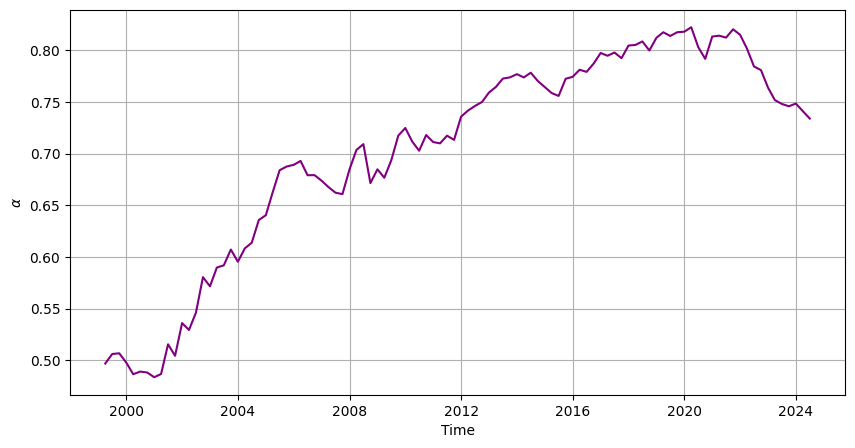

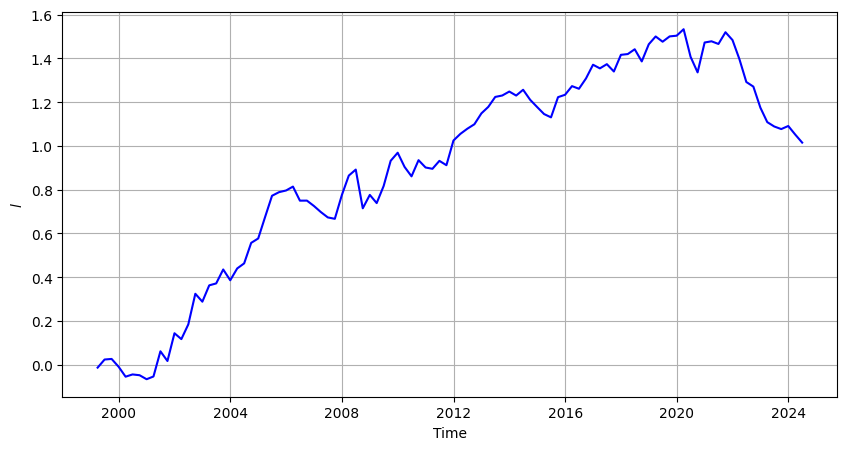

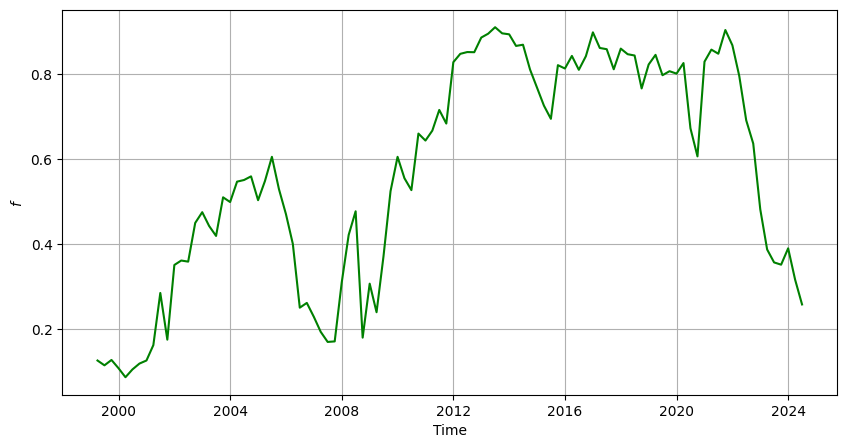

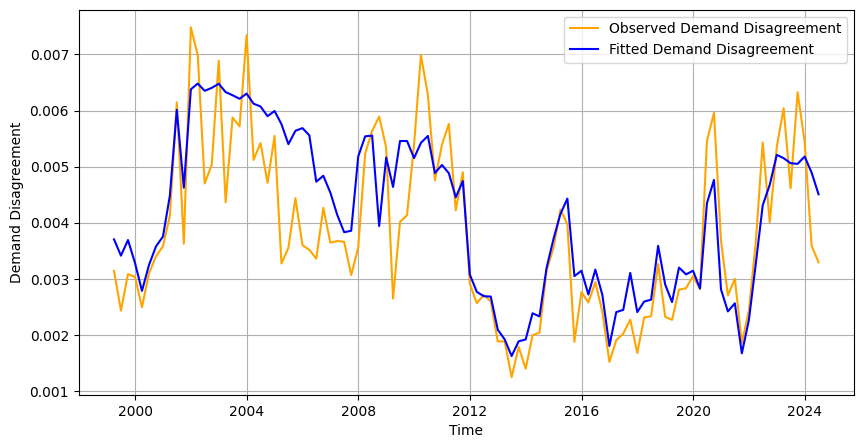

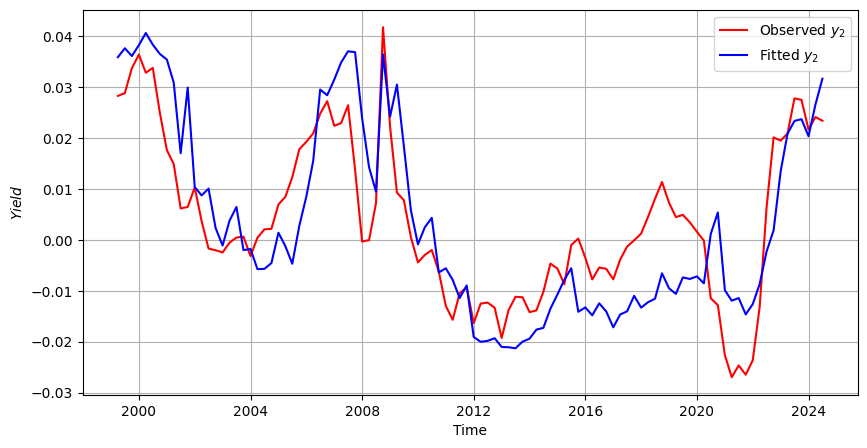

In [ ]:
# Create a time axis with quarterly dates starting from Q1 1999
time = pd.date_range(start='1999Q1', periods=num_timesteps, freq='Q')

# Transform l into alpha using the given formula
alpha = 1 / (1 + np.exp(-np.array(estimated_l)))


# Plot alpha over time
plt.figure(figsize=(10, 5))
plt.plot(time, alpha, label=r'Estimated $\alpha$', color='purple')
plt.xlabel('Time')
plt.ylabel(r'$\alpha$')
#plt.title(r'Estimated $\alpha$ over Time')
#plt.legend()
plt.grid(True)
plt.show()

# Plot estimated l over time
plt.figure(figsize=(10, 5))
plt.plot(time, estimated_l, label='Estimated $l$', color='blue')
plt.xlabel('Time')
plt.ylabel('$l$')
#plt.title('Estimated State Variable l over Time')
#plt.legend()
plt.grid(True)
plt.show()

# Plot estimated f over time
plt.figure(figsize=(10, 5))
plt.plot(time, estimated_f, label='Estimated $f$', color='green')
plt.xlabel('Time')
plt.ylabel('$f$')
#plt.title('Estimated State Variable $f$ over Time')
#plt.legend()
plt.grid(True)
plt.show()

# Plot fitted DIS vs observed DISQ4
plt.figure(figsize=(10, 5))
plt.plot(time, observed_data[:, 0], label='Observed Demand Disagreement', color='orange')
plt.plot(time, fitted_DIS, label='Fitted Demand Disagreement', color='blue')
plt.xlabel('Time')
plt.ylabel('Demand Disagreement')
#plt.title('Fitted vs Observed DIS')
plt.legend()
plt.grid(True)
plt.show()

# Plot fitted B vs observed TIPSY02
plt.figure(figsize=(10, 5))
plt.plot(time, observed_data[:, 1], label='Observed $y_2$', color='red')
plt.plot(time, fitted_B, label='Fitted $y_2$', color='blue')
plt.xlabel('Time')
plt.ylabel('$Yield$')
#plt.title('Fitted vs Observed B')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def getYieldandYieldVola(f, l, tau, pars, M, dt, device):
  rhoA, rhoB, nu, DEL, kap, lbar, sig_l, muY, sigY = pars
  #Since we are doing autodiff we need to make sure we have enabled autograd
  lt = torch.tensor([l], device=device, requires_grad=True)  # Example value
  ft = torch.tensor([f], device=device, requires_grad=True)  # Example value
  #Calculating the yield
  y = getYield(ft, lt, tau, pars, M, dt, device)
  # Compute gradients
  y.backward()
  sigY = ft.grad.item()*ft*(1-ft)*DEL+lt.grad.item()*sig_l
  return y.item(), sigY.item(), ft.grad.item(), lt.grad.item()

In [ ]:
# Function to fit AR(1)-GARCH(1,1) model and extract volatility
def fit_ar1_garch11V2(yield_series):
    # Rescale the data to avoid convergence issues
    yield_series_rescaled = yield_series * 100

    # Fit AR(1)-GARCH(1,1) model
    model = arch_model(yield_series_rescaled, vol='Garch', p=1, q=1, mean='AR', lags=1)
    res = model.fit(disp='off')

    # Extract volatility (conditional standard deviation)
    volatility = res.conditional_volatility / 100  # Scale back the volatility to match original scale
    return volatility

In [ ]:
# Maturities to evaluate
maturities = [2, 3, 5, 7, 10]
# Adjust column names based on whether they need a leading zero
columns = [f'TIPSY0{tau}' if tau < 10 else f'TIPSY{tau}' for tau in maturities]

# Extract yield data for the specified maturities
yield_data = merged_df[columns].values[startObs:] / 100

# Fit AR(1)-GARCH(1,1) model and extract GARCH volatilities for each maturity
garch_volas = {}
for i, tau in enumerate(maturities):
    yield_series = yield_data[:, i]  # Get the yield series for the given maturity
    garch_volas[tau] = fit_ar1_garch11V2(yield_series)  # Store the GARCH volatilities

# Prepare to store model-implied volatilities and yields
implied_volas = {tau: [] for tau in maturities}
implied_yields = {tau: [] for tau in maturities}
implied_riskpremia = {tau: [] for tau in maturities}

# Iterate over each time step for estimation and use UKF estimates
for t in range(num_timesteps):
    # Get current state estimates (l and f) from the UKF output
    l = estimated_l[t]
    f = estimated_f[t]

    # Compute the model-implied yield and volatility for each maturity
    for tau in maturities:
        dtsim = 1/12
        y, sigY, _, _ = getYieldandYieldVola(f, l, tau, pars, M, dtsim, device)
        stdy = np.abs(sigY)
        theta = DEL*(0.5-f)
        rp = -tau*sigY*theta
        implied_riskpremia[tau].append(rp)
        # Store the model-implied yield and volatility
        implied_yields[tau].append(y)
        implied_volas[tau].append(stdy)

# Convert the results into pandas DataFrames for easier analysis
garch_volas_df = pd.DataFrame(garch_volas)
implied_volas_df = pd.DataFrame(implied_volas)
implied_yields_df = pd.DataFrame(implied_yields)
implied_riskpremia_df = pd.DataFrame(implied_riskpremia)


# Print the DataFrames for a quick view of the results
print("GARCH Volatilities:")
print(garch_volas_df.head())

print("\nModel-Implied Volatilities:")
print(implied_volas_df.head())

print("\nModel-Implied Yields:")
print(implied_yields_df.head())

GARCH Volatilities:
         2         3         5         7         10
0       NaN       NaN       NaN       NaN       NaN
1  0.006220  0.004848  0.003998  0.003664  0.003255
2  0.004569  0.003909  0.003376  0.003027  0.002633
3  0.006889  0.005339  0.004252  0.003811  0.003432
4  0.005856  0.004612  0.003579  0.003055  0.002602

Model-Implied Volatilities:
         2         3         5         7         10
0  0.010506  0.010452  0.010357  0.010260  0.010094
1  0.009593  0.009566  0.009523  0.009468  0.009375
2  0.010477  0.010431  0.010339  0.010242  0.010099
3  0.009171  0.009173  0.009129  0.009087  0.009007
4  0.007644  0.007646  0.007668  0.007650  0.007669

Model-Implied Yields:
         2         3         5         7         10
0  0.035878  0.035676  0.035280  0.034831  0.034268
1  0.037645  0.037430  0.036966  0.036518  0.035924
2  0.036070  0.035848  0.035435  0.035010  0.034426
3  0.038259  0.038009  0.037581  0.037161  0.036509
4  0.040639  0.040427  0.039974  0.039567  0

In [ ]:
# Calculate correlations for yields and volatilities
yield_correlations = {}
volatility_correlations = {}

for tau in maturities:
    # Correlation between observed and model-implied yields
    observed_yield_series = yield_data[:, maturities.index(tau)]
    model_yield_series = implied_yields_df[tau]
    yield_corr = np.corrcoef(observed_yield_series, model_yield_series)[0, 1]
    yield_correlations[tau] = yield_corr

    # Handle NaN in the first value of GARCH volatility by excluding it
    garch_vola_series = garch_volas_df[tau].iloc[1:]  # Skip the first value
    model_vola_series = implied_volas_df[tau].iloc[1:]  # Align with the GARCH data

    # Ensure that both series are of the same length after slicing
    min_length = min(len(garch_vola_series), len(model_vola_series))
    garch_vola_series = garch_vola_series[:min_length]
    model_vola_series = model_vola_series[:min_length]

    # Calculate the correlation between GARCH and model-implied volatilities
    vola_corr = np.corrcoef(garch_vola_series, model_vola_series)[0, 1]
    volatility_correlations[tau] = vola_corr

# Print the correlation results
print("Yield Correlations:")
for tau, corr in yield_correlations.items():
    print(f"Maturity {tau}: Correlation between observed and model-implied yields: {corr:.4f}")

print("\nVolatility Correlations:")
for tau, corr in volatility_correlations.items():
    print(f"Maturity {tau}: Correlation between GARCH and model-implied volatilities: {corr:.4f}")

Yield Correlations:
Maturity 2: Correlation between observed and model-implied yields: 0.8351
Maturity 3: Correlation between observed and model-implied yields: 0.8501
Maturity 5: Correlation between observed and model-implied yields: 0.8458
Maturity 7: Correlation between observed and model-implied yields: 0.8316
Maturity 10: Correlation between observed and model-implied yields: 0.8119

Volatility Correlations:
Maturity 2: Correlation between GARCH and model-implied volatilities: 0.1860
Maturity 3: Correlation between GARCH and model-implied volatilities: 0.2850
Maturity 5: Correlation between GARCH and model-implied volatilities: 0.3758
Maturity 7: Correlation between GARCH and model-implied volatilities: 0.3519
Maturity 10: Correlation between GARCH and model-implied volatilities: 0.2724


Running regression between model implied quantities and data quantities. The regression results are reported in Table 5 in the paper. Note that the code here is using fewer random draws so results can vary slightly from time to time. 


In [ ]:
# Clean up column names by removing trailing spaces
merged_df.columns = merged_df.columns.str.strip()

In [ ]:
# Shift only the necessary yields by 4 quarters for future values
merged_df['Y1_t_plus_4'] = merged_df['Y1'].shift(-4)
merged_df['Y2_t_plus_4'] = merged_df['Y2'].shift(-4)
merged_df['Y3_t_plus_4'] = merged_df['Y3'].shift(-4)
merged_df['Y4_t_plus_4'] = merged_df['Y4'].shift(-4)

In [ ]:

# Calculate excess returns
merged_df['rx_2'] = 2 * merged_df['Y2'] - merged_df['Y1_t_plus_4'] - merged_df['Y1']
merged_df['rx_3'] = 3 * merged_df['Y3'] - 2 * merged_df['Y2_t_plus_4'] - merged_df['Y1']
merged_df['rx_4'] = 4 * merged_df['Y4'] - 3 * merged_df['Y3_t_plus_4'] - merged_df['Y1']
merged_df['rx_5'] = 5 * merged_df['Y5'] - 4 * merged_df['Y4_t_plus_4'] - merged_df['Y1']

In [ ]:
# Rename columns for garch_volas_df
garch_volas_df.columns = ['garch2', 'garch3', 'garch5', 'garch7', 'garch10']

# Rename columns for implied_volas_df
implied_volas_df.columns = ['iv2', 'iv3', 'iv5', 'iv7', 'iv10']

# Rename columns for implied_yields_df
implied_yields_df.columns = ['iy2', 'iy3', 'iy5', 'iy7', 'iy10']

# Rename columns for implied_riskpremia_df
implied_riskpremia_df.columns = ['rp2', 'rp3', 'rp5', 'rp7', 'rp10']

estimated_df = pd.DataFrame({
    'l': estimated_l,
    'f': estimated_f
})


In [ ]:
#Creating a dataframe that starts at startObs
df = merged_df.iloc[startObs:].reset_index(drop=True)
df = pd.concat([df, garch_volas_df, estimated_df, implied_volas_df, implied_yields_df, implied_riskpremia_df], axis=1)
df.head()

,YEAR,QUARTER,DISQ1,DISQ2,DISQ3,DISQ4,r_DIS_Q1,r_DIS_Q2,r_DIS_Q3,r_DIS_Q4,...,iy2,iy3,iy5,iy7,iy10,rp2,rp3,rp5,rp7,rp10
0,1999,1,0.081583,0.145798,0.256371,0.314037,0.123016,0.175507,0.278833,0.353196,...,0.035878,0.035676,0.035280,0.034831,0.034268,0.006272,0.009360,0.015457,0.021439,0.030130
1,1999,2,0.096853,0.133745,0.206996,0.243146,0.150591,0.184876,0.279494,0.334529,...,0.037645,0.037430,0.036966,0.036518,0.035924,0.005901,0.008826,0.014644,0.020383,0.028831
2,1999,3,0.149919,0.231050,0.301618,0.308235,0.204648,0.247642,0.297854,0.311727,...,0.036070,0.035848,0.035435,0.035010,0.034426,0.006233,0.009308,0.015378,0.021327,0.030040
3,1999,4,0.170787,0.216124,0.277539,0.303241,0.277183,0.323934,0.355474,0.397502,...,0.038259,0.038009,0.037581,0.037161,0.036509,0.005740,0.008612,0.014285,0.019906,0.028187
4,2000,1,0.138896,0.220195,0.214027,0.249303,0.227426,0.282490,0.296315,0.344477,...,0.040639,0.040427,0.039974,0.039567,0.038894,0.005043,0.007567,0.012647,0.017664,0.025300


In [ ]:
import statsmodels.api as sm

filtered_data = df.dropna(subset=['rx_2', 'rx_3','rx_5', 'rp2','rp3','rp5'])

# Define the pairs of dependent and independent variables
rx_cols = ['rx_2', 'rx_3', 'rx_5']
rp_cols = ['rp2', 'rp3', 'rp5']

# Run predictive regressions for each rx_n onto the corresponding rp_n
for rx_col, rp_col in zip(rx_cols, rp_cols):
    X = filtered_data[rp_col]  # Independent variable
    y = filtered_data[rx_col]  # Dependent variable

    # Add a constant to the independent variable (for the intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})

    # Print the regression summary
    print(f"Regression results for {rx_col} on {rp_col}:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Regression results for rx_2 on rp2:
                            OLS Regression Results                            
Dep. Variable:                   rx_2   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     6.817
Date:                Wed, 03 Sep 2025   Prob (F-statistic):             0.0105
Time:                        23:38:48   Log-Likelihood:                 295.99
No. Observations:                  98   AIC:                            -588.0
Df Residuals:                      96   BIC:                            -582.8
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [ ]:
filtered_data = df.dropna(subset=['garch2', 'garch3','garch5', 'garch7', 'garch10','iv2','iv3','iv5','iv7', 'iv10'])

# Define the pairs of dependent and independent variables
rx_cols = ['garch2', 'garch3','garch5', 'garch7', 'garch10']
rp_cols = ['iv2','iv3','iv5','iv7', 'iv10']

# Run predictive regressions for each rx_n onto the corresponding rp_n
for rx_col, rp_col in zip(rx_cols, rp_cols):
    X = filtered_data[rp_col]  # Independent variable
    y = filtered_data[rx_col]  # Dependent variable

    # Add a constant to the independent variable (for the intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})

    # Print the regression summary
    print(f"Regression results for {rx_col} on {rp_col}:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Regression results for garch2 on iv2:
                            OLS Regression Results                            
Dep. Variable:                 garch2   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.230
Date:                Wed, 03 Sep 2025   Prob (F-statistic):              0.139
Time:                        23:38:48   Log-Likelihood:                 424.38
No. Observations:                 101   AIC:                            -844.8
Df Residuals:                      99   BIC:                            -839.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         

In [ ]:
filtered_data = df.dropna(subset=['TIPSY02', 'TIPSY03','TIPSY05', 'TIPSY07', 'TIPSY10','iy2','iy3','iy5','iy7', 'iy10'])

# Define the pairs of dependent and independent variables
rx_cols = ['TIPSY02', 'TIPSY03','TIPSY05', 'TIPSY07', 'TIPSY10']
rp_cols = ['iy2','iy3','iy5','iy7', 'iy10']

# Run predictive regressions for each rx_n onto the corresponding rp_n
for rx_col, rp_col in zip(rx_cols, rp_cols):
    X = filtered_data[rp_col]  # Independent variable
    y = filtered_data[rx_col]/100  # Dependent variable

    # Add a constant to the independent variable (for the intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X)
    results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})

    # Print the regression summary
    print(f"Regression results for {rx_col} on {rp_col}:")
    print(results.summary())
    print("\n" + "="*80 + "\n")

Regression results for TIPSY02 on iy2:
                            OLS Regression Results                            
Dep. Variable:                TIPSY02   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                     119.4
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           9.27e-19
Time:                        23:38:48   Log-Likelihood:                 340.89
No. Observations:                 102   AIC:                            -677.8
Df Residuals:                     100   BIC:                            -672.5
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [ ]:
X = filtered_data['iy10']-filtered_data['iy2']  # Independent variable
y = (filtered_data['TIPSY10']-filtered_data['TIPSY02'])/100  # Dependent variable

# Add a constant to the independent variable (for the intercept)
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X)
results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 4})

# Print the regression summary
print(f"Regression results for {rx_col} on {rp_col}:")
print(results.summary())
print("\n" + "="*80 + "\n")

Regression results for TIPSY10 on iy10:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     18.50
Date:                Wed, 03 Sep 2025   Prob (F-statistic):           3.96e-05
Time:                        23:38:48   Log-Likelihood:                 353.75
No. Observations:                 102   AIC:                            -703.5
Df Residuals:                     100   BIC:                            -698.2
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       